<a href="https://colab.research.google.com/github/Ken89MathCompSci/University_of_Glasgow_PhD_Codes_Year_One/blob/main/Actual_LTC_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ctrnn_layer (CTRNNLayer)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1626 - val_loss: 0.0143
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0172 - val_loss: 0.0134
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0151 - val_loss: 0.0116
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0124 - val_loss: 0.0110
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0129 - val_loss: 0.0132
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0138 - val_loss: 0.0125
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0122 - val_loss: 0.0106
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0

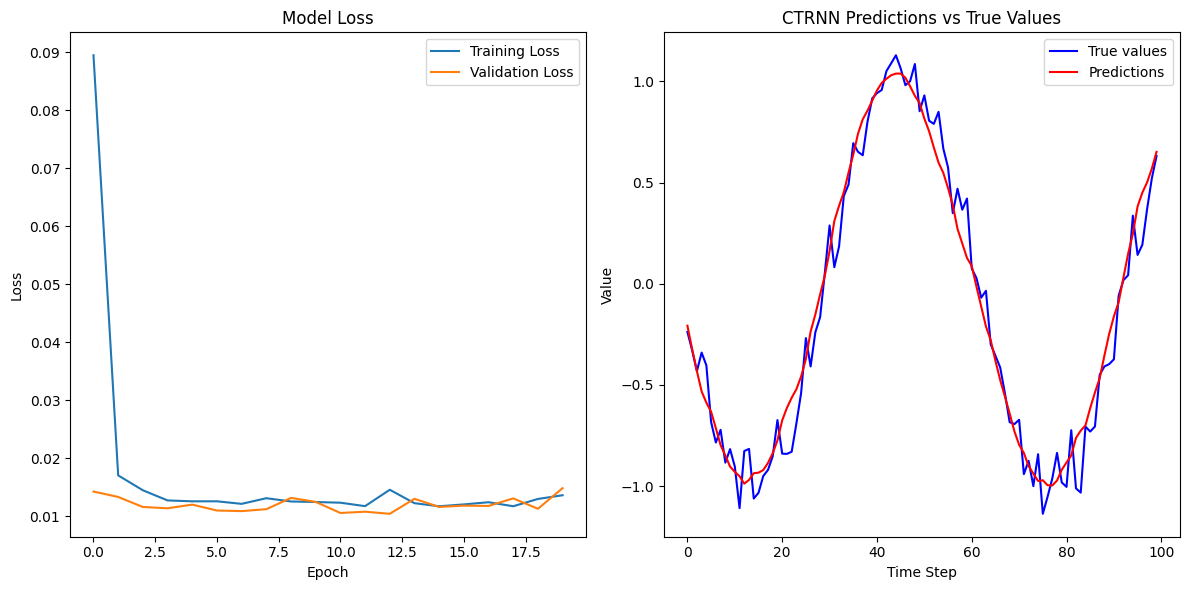

In [3]:
# CTRNN implementation
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# For TensorFlow 2.x, the RNNCell is in keras.layers
from tensorflow.keras.layers import Layer, Dense, RNN

# Updated CTRNN class compatible with TensorFlow 2.x as an RNNCell
class CTRNN(Layer):
    def __init__(self, units, cell_clip=-1, global_feedback=False, fix_tau=True, **kwargs):
        super(CTRNN, self).__init__(**kwargs)
        self.units = units
        self._unfolds = 6
        self._delta_t = 0.1
        self.global_feedback = global_feedback
        self.fix_tau = fix_tau
        self.tau = 1.0
        self.cell_clip = cell_clip

        # Add state_size and output_size properties required by Keras RNN
        self.state_size = units
        self.output_size = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if not self.fix_tau:
            self.tau_var = self.add_weight(
                name='tau',
                shape=[],
                initializer=tf.constant_initializer(self.tau),
                trainable=True
            )

        if not self.global_feedback:
            self.kernel = self.add_weight(
                name='kernel',
                shape=[input_dim, self.units],
                initializer='glorot_uniform',
                trainable=True
            )
            self.bias = self.add_weight(
                name='bias',
                shape=[self.units],
                initializer='zeros',
                trainable=True
            )
        else:
            # Will create these weights during call if needed
            self.kernel = None
            self.bias = None

        if self.global_feedback:
            # For global feedback mode, we'll need weights for combined input+state
            self.feedback_kernel = self.add_weight(
                name='feedback_kernel',
                shape=[input_dim + self.units, self.units],
                initializer='glorot_uniform',
                trainable=True
            )
            self.feedback_bias = self.add_weight(
                name='feedback_bias',
                shape=[self.units],
                initializer='zeros',
                trainable=True
            )

        self.built = True

    def _dense(self, inputs, kernel, bias):
        outputs = tf.matmul(inputs, kernel) + bias
        return tf.nn.tanh(outputs)

    def call(self, inputs, states):
        # In TF2, RNN state comes as a list
        state = states[0]

        # Get tau value
        if not self.fix_tau:
            tau = tf.nn.softplus(self.tau_var)
        else:
            tau = self.tau

        # For non-global feedback, compute input transformation once
        if not self.global_feedback:
            input_f_prime = self._dense(inputs, self.kernel, self.bias)

        # Unfold the ODE solver steps
        for i in range(self._unfolds):
            # For global feedback, compute input+state transformation for each step
            if self.global_feedback:
                fused_input = tf.concat([inputs, state], axis=-1)
                input_f_prime = self._dense(fused_input, self.feedback_kernel, self.feedback_bias)

            # Compute derivative: df/dt
            f_prime = -state/tau + input_f_prime

            # Euler integration step
            state = state + self._delta_t * f_prime

            # Optional clipping
            if self.cell_clip > 0:
                state = tf.clip_by_value(state, -self.cell_clip, self.cell_clip)

        return state, [state]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            if batch_size is None:
                raise ValueError("If inputs is None, batch_size must be provided")
            if dtype is None:
                dtype = tf.float32

        return [tf.zeros((batch_size, self.units), dtype=dtype)]

    def get_config(self):
        config = super(CTRNN, self).get_config()
        config.update({
            'units': self.units,
            'cell_clip': self.cell_clip,
            'global_feedback': self.global_feedback,
            'fix_tau': self.fix_tau
        })
        return config

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Create a simple sine wave dataset for demonstration
def generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1):
    """Generate sine wave data for sequence prediction."""
    time = np.arange(0, samples + sequence_length)
    # Generate a sine wave with some noise
    sine_wave = np.sin(0.1 * time) + 0.1 * np.random.randn(len(time))

    # Create input-output pairs (X predicts next Y)
    X = np.zeros((samples, sequence_length, feature_dim))
    y = np.zeros((samples, feature_dim))

    for i in range(samples):
        X[i, :, 0] = sine_wave[i:i+sequence_length]
        y[i, 0] = sine_wave[i+sequence_length]

    # Split into train and test
    train_size = int(0.8 * samples)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, y_train, X_test, y_test

# Generate data
X_train, y_train, X_test, y_test = generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1)

# A different approach for TF2 - using a subclass of keras.Layer.RNN directly
class CTRNNLayer(RNN):
    def __init__(self, units, return_sequences=False, return_state=False,
                 cell_clip=-1, global_feedback=False, fix_tau=True, **kwargs):
        self.units = units
        self.cell_clip = cell_clip
        self.global_feedback = global_feedback
        self.fix_tau = fix_tau

        # Create the cell
        cell = CTRNN(units=units, cell_clip=cell_clip,
                    global_feedback=global_feedback, fix_tau=fix_tau)

        # Pass the cell to the RNN parent class
        super(CTRNNLayer, self).__init__(
            cell=cell,
            return_sequences=return_sequences,
            return_state=return_state,
            **kwargs
        )

    def get_config(self):
        config = super(CTRNNLayer, self).get_config()
        config.update({
            'units': self.units,
            'cell_clip': self.cell_clip,
            'global_feedback': self.global_feedback,
            'fix_tau': self.fix_tau
        })
        return config

# Define model parameters
rnn_units = 32
input_shape = (50, 1)  # (sequence_length, features)

# Create a simpler sequential model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    CTRNNLayer(units=rnn_units, global_feedback=True, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mse'
)

# Print model summary
model.summary()

# Training parameters
epochs = 20
batch_size = 64

# Convert data to TensorFlow datasets for better performance
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

# Train the model using Keras fit
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset.take(5),
    verbose=1
)

# Evaluate on test set
test_loss = model.evaluate(test_dataset, verbose=0)
print(f"Test MSE: {test_loss:.6f}")

# Make predictions
test_predictions = model.predict(X_test)

# Plot results for visualization
plt.figure(figsize=(12, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot a sample of test predictions vs ground truth
plt.subplot(1, 2, 2)
sample_size = 100
plt.plot(y_test[:sample_size, 0], 'b-', label='True values')
plt.plot(test_predictions[:sample_size, 0], 'r-', label='Predictions')
plt.legend()
plt.title('CTRNN Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')

# Save the plot
plt.tight_layout()
#plt.savefig('ctrnn_predictions.png')
#plt.close()
plt.show()

# Optional: Save model
#model.save_weights('ctrnn_model_weights.weights.h5')
#print("Model training complete and visualization saved!")

# If you want to see predictions more clearly
plt.figure(figsize=(14, 6))
plt.plot(y_test[:200, 0], 'b-', label='True values')
plt.plot(test_predictions[:200, 0], 'r-', label='Predictions')
plt.legend()
plt.title('CTRNN Predictions vs True Values (Extended View)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.savefig('ctrnn_predictions_extended.png')
plt.close()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_2 (RNN)                     │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 352ms/step - loss: 94.4653 - val_loss: 18.2304
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 25.6071 - val_loss: 12.1456
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 16.0095 - val_loss: 8.8730
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 7.4667 - val_loss: 6.8533
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 5.4972 - val_loss: 4.5239
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 4.2461 - val_loss: 3.7097
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 3.4364 - val_loss: 3.7521
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 4.0260 - val_loss: 4.2441
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 6.6062 - val_loss: 13.0609
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 12.6022 - val_loss: 9.7607
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 10.3845 - val_loss: 6.2681
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step


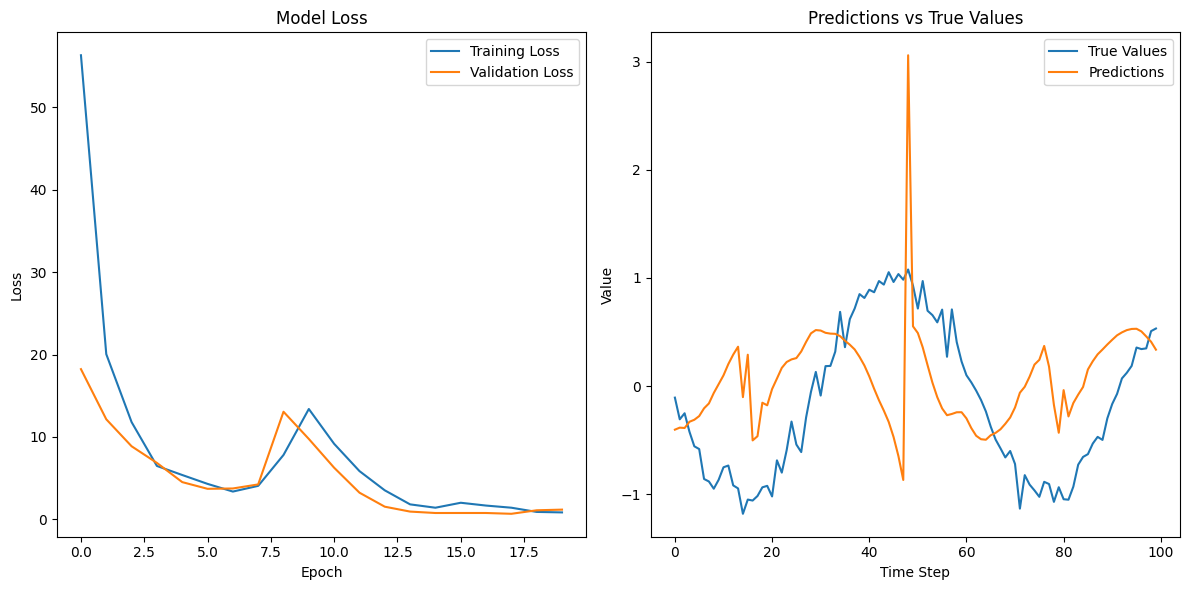

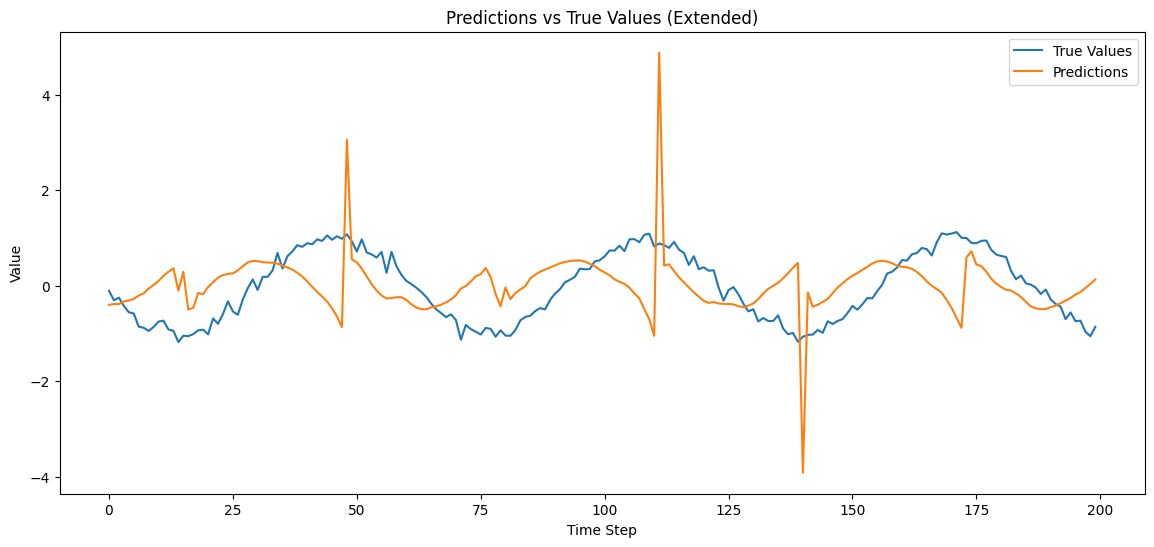

In [4]:
# NODE implementation

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

class NODE(tf.keras.layers.Layer):
    def __init__(self, units, time_step=0.1, unfolds=6, cell_clip=-1, **kwargs):
        super(NODE, self).__init__(**kwargs)
        self.units = units
        self.time_step = time_step
        self.unfolds = unfolds
        self.cell_clip = cell_clip
        self.state_size = units  # Define state_size for RNN layer
        self.output_size = units # Define output_size for RNN layer

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim + self.units, self.units),
                                 initializer='glorot_uniform',
                                 name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias')
        super(NODE, self).build(input_shape)

    def _dense(self, inputs):
        return tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)

    def _ode_step_runge_kutta(self, inputs, state):
        for _ in range(self.unfolds):
            k1 = self.time_step * self._f_prime(inputs, state)
            k2 = self.time_step * self._f_prime(inputs, state + k1 * 0.5)
            k3 = self.time_step * self._f_prime(inputs, state + k2 * 0.5)
            k4 = self.time_step * self._f_prime(inputs, state + k3)
            state = state + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
            if self.cell_clip > 0:
                state = tf.clip_by_value(state, -self.cell_clip, self.cell_clip)
        return state

    def _f_prime(self, inputs, state):
        # Use TensorFlow control flow instead of Python if statement
        # Get the rank and handle reshaping with tf operations
        rank = tf.rank(inputs)
        # Use tf.cond instead of Python if-else
        inputs = tf.cond(
            rank > 2,
            lambda: tf.squeeze(inputs, axis=1),
            lambda: inputs
        )
        fused_input = tf.concat([inputs, state], axis=-1)
        return self._dense(fused_input)

    def call(self, inputs, state):
        # Ensure state is just a tensor, not a tuple containing a tensor
        if isinstance(state, tuple) and len(state) == 1:
            state = state[0]
        next_state = self._ode_step_runge_kutta(inputs, state)
        return next_state, next_state

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            # Provide default values if inputs is None
            if batch_size is None:
                batch_size = 1
            if dtype is None:
                dtype = tf.float32
        return tf.zeros((batch_size, self.units), dtype=dtype)

    def get_config(self):
        config = super(NODE, self).get_config()
        config.update({
            'units': self.units,
            'time_step': self.time_step,
            'unfolds': self.unfolds,
            'cell_clip': self.cell_clip
        })
        return config

# Generate sine wave data
def generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1):
    time = np.arange(0, samples + sequence_length)
    sine_wave = np.sin(0.1 * time) + 0.1 * np.random.randn(len(time))
    X = np.zeros((samples, sequence_length, feature_dim))
    y = np.zeros((samples, feature_dim))
    for i in range(samples):
        X[i, :, 0] = sine_wave[i:i+sequence_length]
        y[i, 0] = sine_wave[i+sequence_length]
    train_size = int(0.8 * samples)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, y_train, X_test, y_test

# Generate data
X_train, y_train, X_test, y_test = generate_sine_wave_data()

# Define model parameters
rnn_units = 32
input_shape = (50, 1)
feature_length = 1

# Create a Sequential model with the NODE layer
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.RNN(NODE(units=rnn_units), return_sequences=False, stateful=False),
    tf.keras.layers.Dense(feature_length)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Training parameters
epochs = 20
batch_size = 64

# Enable eager execution for debugging if needed
# tf.config.run_functions_eagerly(True)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs true values
plt.subplot(1, 2, 2)
sample_size = 100
plt.plot(y_test[:sample_size], label='True Values')
plt.plot(predictions[:sample_size], label='Predictions')
plt.title('Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Extended view of predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test[:200], label='True Values')
plt.plot(predictions[:200], label='Predictions')
plt.title('Predictions vs True Values (Extended)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_3 (RNN)                     │ (None, 32)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,529 (72.38 KB)

 Trainable params: 18,529 (72.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.5404 - val_loss: 0.4966
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.5182 - val_loss: 0.4767
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.4968 - val_loss: 0.4571
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.4754 - val_loss: 0.4372
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.4536 - val_loss: 0.4165
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.4308 - val_loss: 0.3945
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.4064 - val_loss: 0.3703
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.3794 - val_loss: 0.3430
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.3488 - val_loss: 0.3115
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.3130 - val_loss: 0.2738
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.2698 - val_loss: 0.2276
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


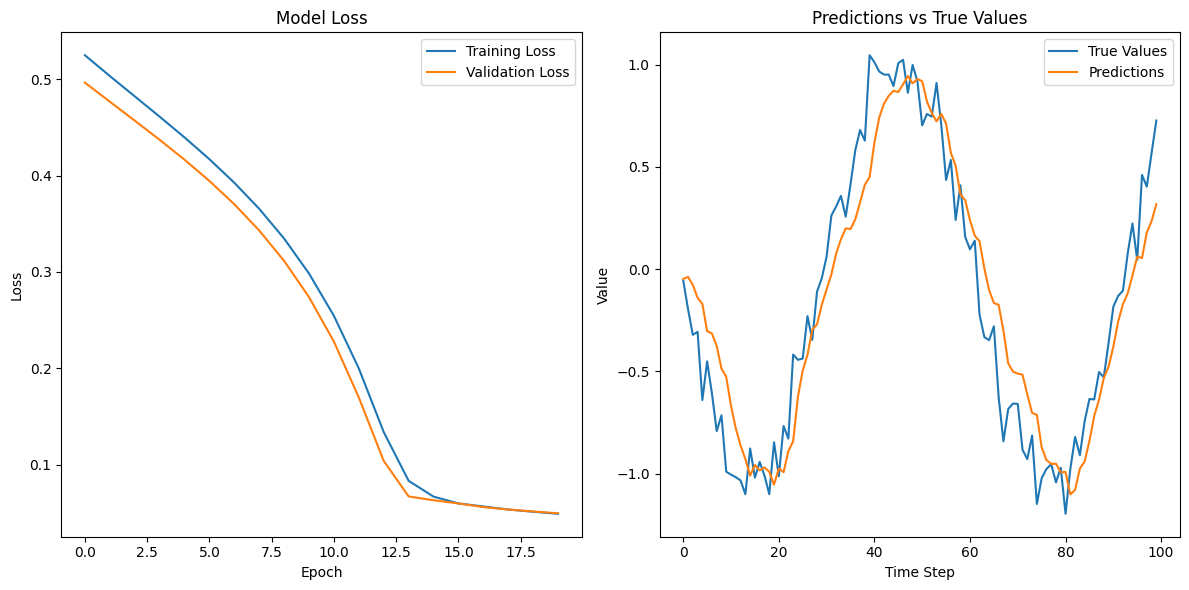

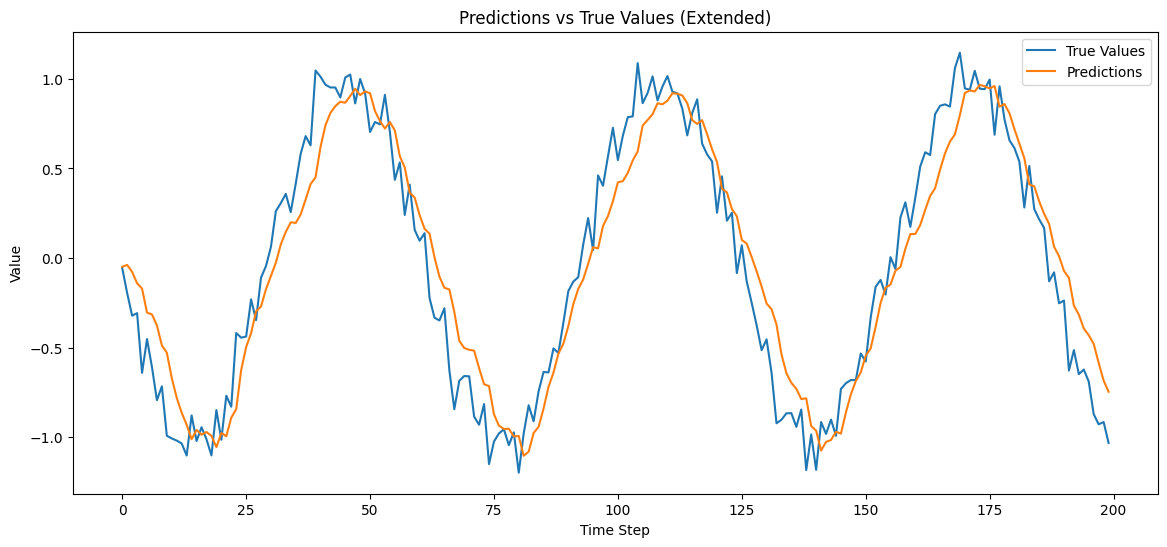

In [5]:
# CTGRU implementation

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

class CTGRU(tf.keras.layers.Layer):
    def __init__(self, units, M=8, cell_clip=-1, **kwargs):
        super(CTGRU, self).__init__(**kwargs)
        self.units = units
        self.M = M
        self.cell_clip = cell_clip
        self.state_size = units * M  # Define state_size for RNN layer
        self.output_size = units     # Define output_size for RNN layer

        # Create the ln_tau_table
        self.ln_tau_table = np.empty(self.M)
        tau = 1
        for i in range(self.M):
            self.ln_tau_table[i] = np.log(tau)
            tau = tau * (10.0**0.5)

        # Convert to tensor constant
        self.ln_tau_table = tf.constant(self.ln_tau_table, dtype=tf.float32)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Build weights for tau_r gate
        self.tau_r_kernel = self.add_weight(
            shape=(input_dim + self.units, self.units * self.M),
            initializer='glorot_uniform',
            name='tau_r_kernel')
        self.tau_r_bias = self.add_weight(
            shape=(self.units * self.M,),
            initializer='zeros',
            name='tau_r_bias')

        # Build weights for signal detection
        self.q_kernel = self.add_weight(
            shape=(input_dim + self.units, self.units),
            initializer='glorot_uniform',
            name='q_kernel')
        self.q_bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='q_bias')

        # Build weights for tau_s gate
        self.tau_s_kernel = self.add_weight(
            shape=(input_dim + self.units, self.units * self.M),
            initializer='glorot_uniform',
            name='tau_s_kernel')
        self.tau_s_bias = self.add_weight(
            shape=(self.units * self.M,),
            initializer='zeros',
            name='tau_s_bias')

        super(CTGRU, self).build(input_shape)

    def _dense(self, inputs, kernel, bias, activation=None):
        y = tf.matmul(inputs, kernel) + bias
        if activation is not None:
            y = activation(y)
        return y

    def call(self, inputs, state):
        # Handle state properly if it comes as a tuple
        if isinstance(state, tuple) and len(state) == 1:
            state = state[0]

        # Reshape the state into a 3D tensor [batch, units, M]
        h_hat = tf.reshape(state, [-1, self.units, self.M])

        # Sum across time-scale dimension to get the current hidden state
        h = tf.reduce_sum(h_hat, axis=2)

        # Concatenate input and hidden state
        fused_input = tf.concat([inputs, h], axis=-1)

        # Calculate reset gate (tau_r)
        ln_tau_r = self._dense(fused_input, self.tau_r_kernel, self.tau_r_bias)
        ln_tau_r = tf.reshape(ln_tau_r, shape=[-1, self.units, self.M])

        # Softmax for reset gate across time scales
        sf_input_r = -tf.square(ln_tau_r - self.ln_tau_table)
        rki = tf.nn.softmax(logits=sf_input_r, axis=2)

        # Calculate reset context
        q_input = tf.reduce_sum(rki * h_hat, axis=2)
        reset_value = tf.concat([inputs, q_input], axis=1)

        # Calculate candidate activation
        qk = self._dense(reset_value, self.q_kernel, self.q_bias, activation=tf.nn.tanh)
        qk = tf.reshape(qk, [-1, self.units, 1])  # Reshape for broadcasting

        # Calculate update gate (tau_s)
        ln_tau_s = self._dense(fused_input, self.tau_s_kernel, self.tau_s_bias)
        ln_tau_s = tf.reshape(ln_tau_s, shape=[-1, self.units, self.M])

        # Softmax for update gate across time scales
        sf_input_s = -tf.square(ln_tau_s - self.ln_tau_table)
        ski = tf.nn.softmax(logits=sf_input_s, axis=2)

        # Update hidden state with time-scale decay
        decay_factor = tf.exp(-1.0/self.ln_tau_table)
        h_hat_next = ((1 - ski) * h_hat + ski * qk) * decay_factor

        # Apply cell clipping if configured
        if self.cell_clip > 0:
            h_hat_next = tf.clip_by_value(h_hat_next, -self.cell_clip, self.cell_clip)

        # Compute output and flatten state for storage
        h_next = tf.reduce_sum(h_hat_next, axis=2)
        h_hat_next_flat = tf.reshape(h_hat_next, shape=[-1, self.units * self.M])

        return h_next, h_hat_next_flat

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            if batch_size is None:
                batch_size = 1
            if dtype is None:
                dtype = tf.float32

        # Return zeros shaped for the flattened state
        return tf.zeros((batch_size, self.units * self.M), dtype=dtype)

    def get_config(self):
        config = super(CTGRU, self).get_config()
        config.update({
            'units': self.units,
            'M': self.M,
            'cell_clip': self.cell_clip
        })
        return config

# Example usage with the same sine wave prediction task:
def generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1):
    time = np.arange(0, samples + sequence_length)
    sine_wave = np.sin(0.1 * time) + 0.1 * np.random.randn(len(time))
    X = np.zeros((samples, sequence_length, feature_dim))
    y = np.zeros((samples, feature_dim))
    for i in range(samples):
        X[i, :, 0] = sine_wave[i:i+sequence_length]
        y[i, 0] = sine_wave[i+sequence_length]
    train_size = int(0.8 * samples)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, y_train, X_test, y_test

# Generate data
X_train, y_train, X_test, y_test = generate_sine_wave_data()

# Define model parameters
rnn_units = 32
M = 8  # Number of timescales for CTGRU
input_shape = (50, 1)
feature_length = 1

# Create a Sequential model with the CTGRU layer
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.RNN(CTGRU(units=rnn_units, M=M), return_sequences=False, stateful=False),
    tf.keras.layers.Dense(feature_length)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Training parameters
epochs = 20
batch_size = 64

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Make predictions
predictions = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs true values
plt.subplot(1, 2, 2)
sample_size = 100
plt.plot(y_test[:sample_size], label='True Values')
plt.plot(predictions[:sample_size], label='Predictions')
plt.title('Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Extended view of predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test[:200], label='True Values')
plt.plot(predictions[:200], label='Predictions')
plt.title('Predictions vs True Values (Extended)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

Training NODE model...
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - loss: 5429.5913 - val_loss: 1731.9084
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 1341.1788 - val_loss: 476.1932
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 411.7854 - val_loss: 150.8719
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 148.7540 - val_loss: 43.2229
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 45.6513 - val_loss: 24.6358
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 27.1642 - val_loss: 15.5374
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 17.9459 - val_loss: 9.1336
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 9.6830 - val_loss: 6.1586
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 7.3154 - val_loss: 5.8791
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 6.1278 - val_loss: 6.6311
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 5.7623 - val_loss: 4.7131
Epoch

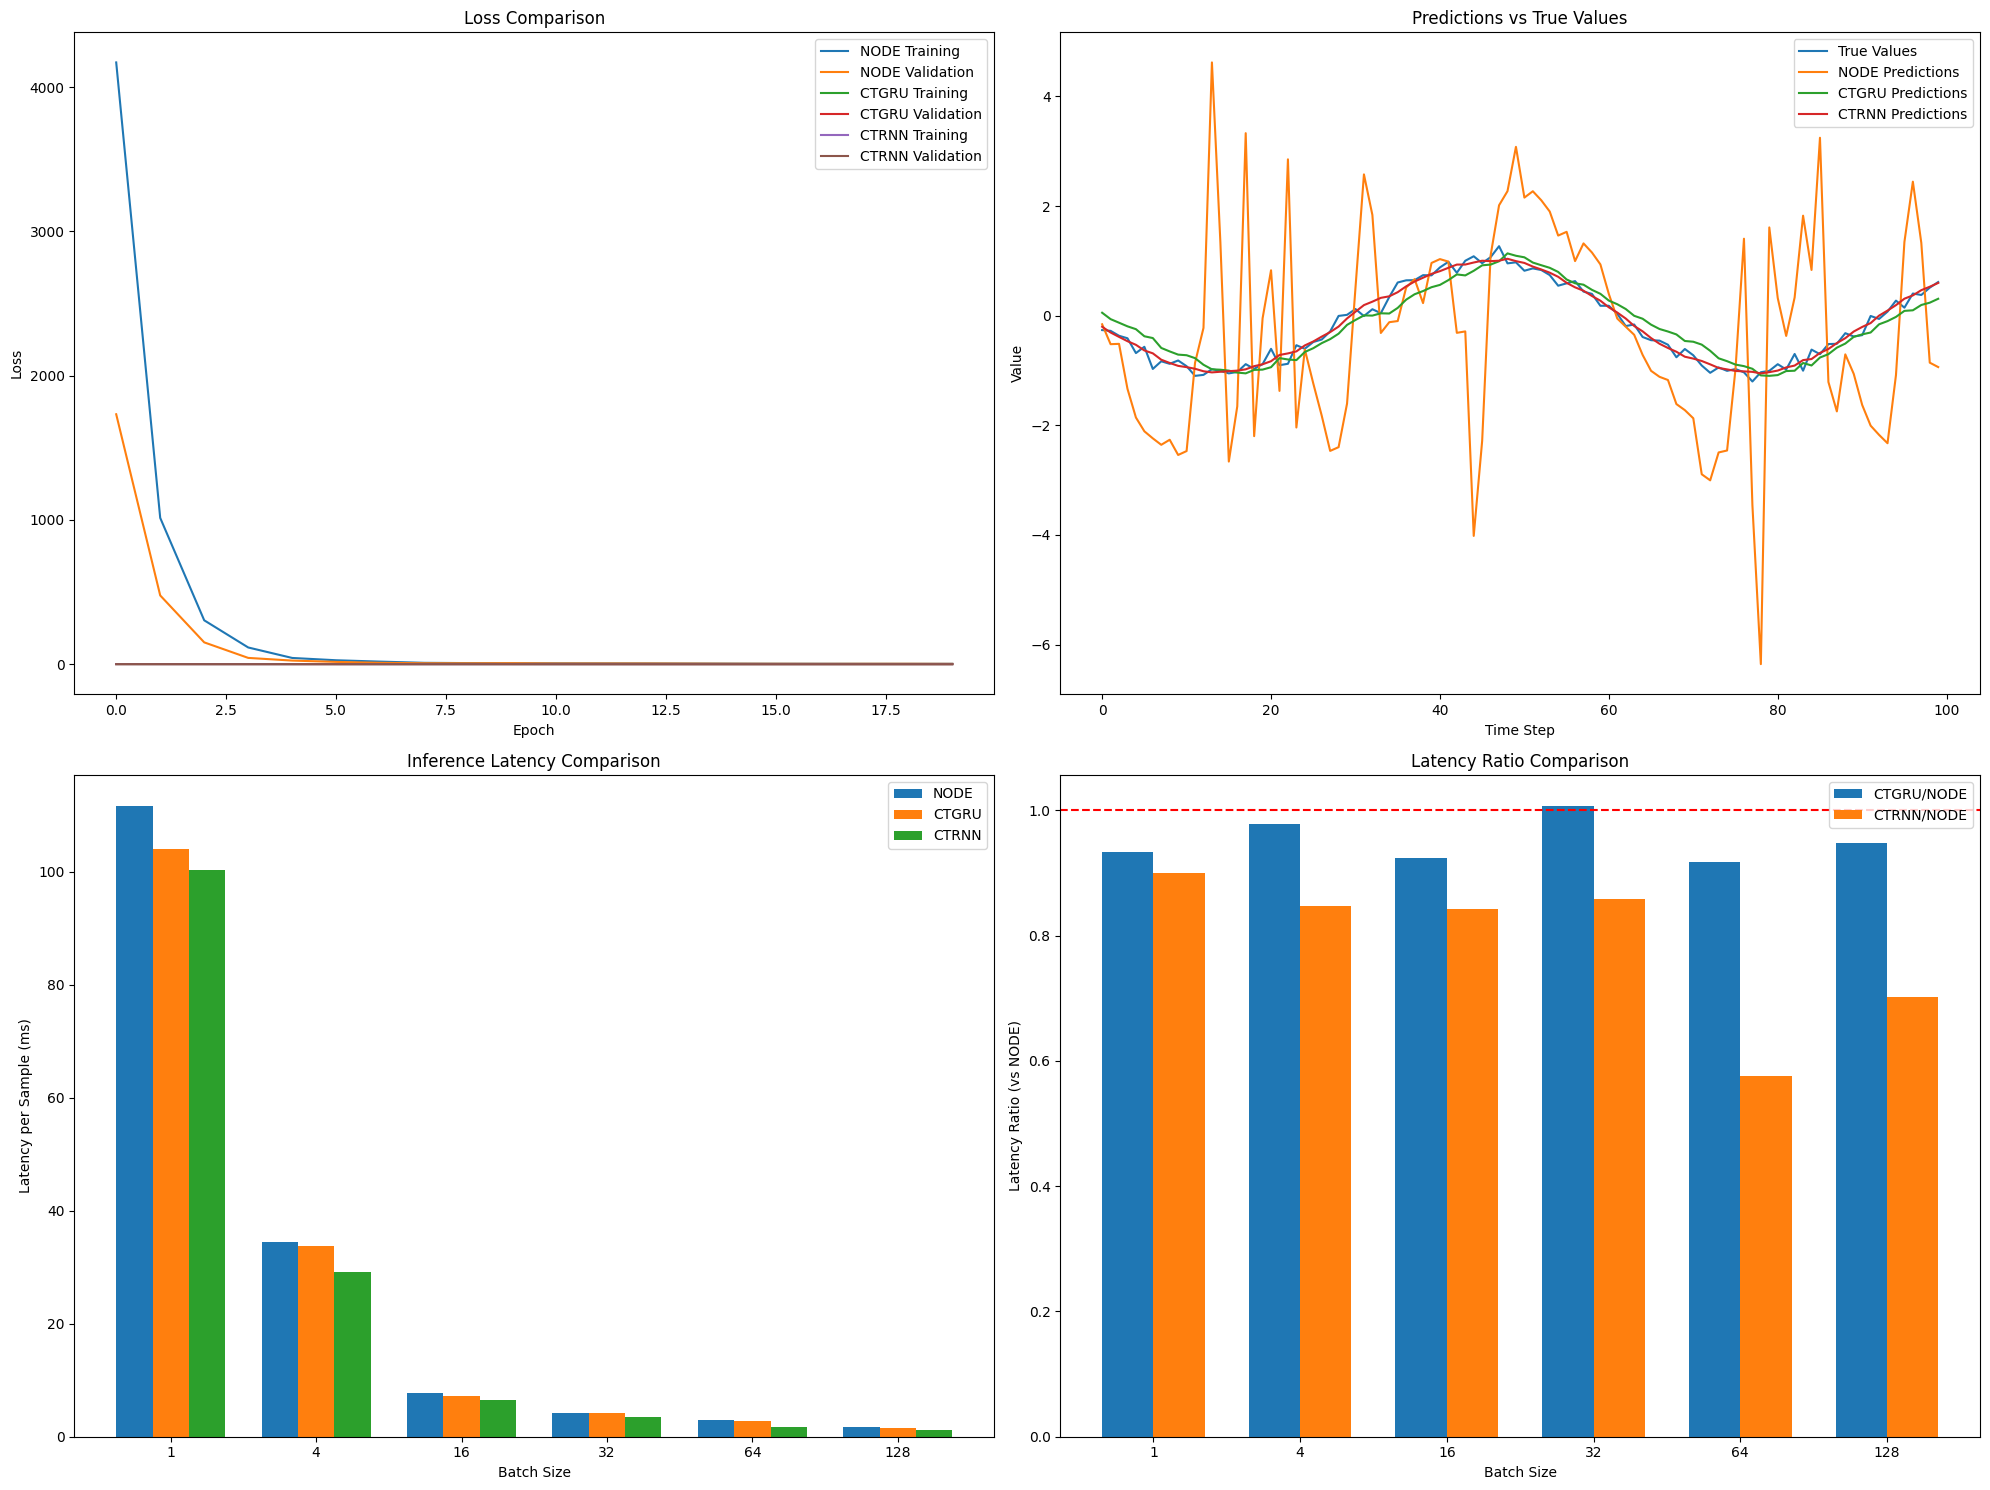

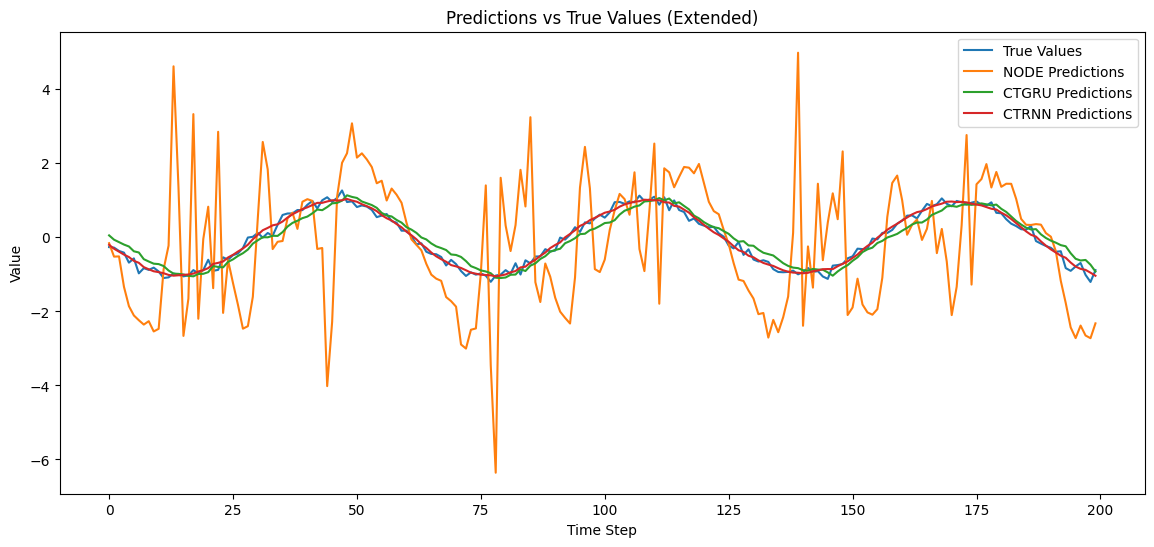

Average NODE latency per sample (ms): 27.110457352052133
Average CTGRU latency per sample (ms): 25.589209515601397
Average CTRNN latency per sample (ms): 23.760753261546295
Average latency ratio (CTGRU/NODE): 0.9513093054390204
Average latency ratio (CTRNN/NODE): 0.7876766635624787

Model Parameter Counts:
NODE: 1121 parameters
CTGRU: 18529 parameters
CTRNN: 1121 parameters
CTGRU has 16.53x the parameters of NODE
CTRNN has 1.00x the parameters of NODE


In [6]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# CTRNN Implementation
class CTRNN(tf.keras.layers.Layer):
    def __init__(self, units, time_step=0.1, unfolds=6, cell_clip=-1, global_feedback=True, fix_tau=True, **kwargs):
        super(CTRNN, self).__init__(**kwargs)
        self.units = units
        self.time_step = time_step
        self.unfolds = unfolds
        self.cell_clip = cell_clip
        self.global_feedback = global_feedback
        self.fix_tau = fix_tau
        self.tau = 1.0
        self.state_size = units  # Define state_size for RNN layer
        self.output_size = units # Define output_size for RNN layer

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Create weights for the network
        if self.global_feedback:
            self.W = self.add_weight(shape=(input_dim + self.units, self.units),
                                     initializer='glorot_uniform',
                                     name='kernel')
        else:
            self.W = self.add_weight(shape=(input_dim, self.units),
                                     initializer='glorot_uniform',
                                     name='kernel')

        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias')

        # Create tau variable if not fixed
        if not self.fix_tau:
            self.tau_var = self.add_weight(shape=(),
                                          initializer=tf.constant_initializer(np.log(self.tau - 0.01)),
                                          name='tau')

        super(CTRNN, self).build(input_shape)

    def _dense(self, inputs):
        return tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)

    def call(self, inputs, state):
        # Handle state properly if it comes as a tuple
        if isinstance(state, tuple) and len(state) == 1:
            state = state[0]

        # Get tau value (fixed or learned)
        if not self.fix_tau:
            tau = tf.nn.softplus(self.tau_var) + 0.01  # Make sure tau is positive
        else:
            tau = self.tau

        # Compute f_prime (derivative)
        if not self.global_feedback:
            # Input option 1: Only use RNN cell input (compute once outside the loop)
            input_f_prime = self._dense(inputs)

        # Unfold the ODE multiple steps
        for _ in range(self.unfolds):
            if self.global_feedback:
                # Input option 2: Use RNN cell input AND current state
                fused_input = tf.concat([inputs, state], axis=-1)
                input_f_prime = self._dense(fused_input)

            # df/dt
            f_prime = -state/tau + input_f_prime

            # If we solve this ODE with explicit euler we get
            # f(t+deltaT) = f(t) + deltaT * df/dt
            state = state + self.time_step * f_prime

            # Optional clipping of the RNN cell for stability
            if self.cell_clip > 0:
                state = tf.clip_by_value(state, -self.cell_clip, self.cell_clip)

        return state, state

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            if batch_size is None:
                batch_size = 1
            if dtype is None:
                dtype = tf.float32
        return tf.zeros((batch_size, self.units), dtype=dtype)

    def get_config(self):
        config = super(CTRNN, self).get_config()
        config.update({
            'units': self.units,
            'time_step': self.time_step,
            'unfolds': self.unfolds,
            'cell_clip': self.cell_clip,
            'global_feedback': self.global_feedback,
            'fix_tau': self.fix_tau,
            'tau': self.tau
        })
        return config

# NODE Implementation (same as before)
class NODE(tf.keras.layers.Layer):
    def __init__(self, units, time_step=0.1, unfolds=6, cell_clip=-1, **kwargs):
        super(NODE, self).__init__(**kwargs)
        self.units = units
        self.time_step = time_step
        self.unfolds = unfolds
        self.cell_clip = cell_clip
        self.state_size = units  # Define state_size for RNN layer
        self.output_size = units # Define output_size for RNN layer

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim + self.units, self.units),
                                 initializer='glorot_uniform',
                                 name='kernel')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias')
        super(NODE, self).build(input_shape)

    def _dense(self, inputs):
        return tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)

    def _ode_step_runge_kutta(self, inputs, state):
        for _ in range(self.unfolds):
            k1 = self.time_step * self._f_prime(inputs, state)
            k2 = self.time_step * self._f_prime(inputs, state + k1 * 0.5)
            k3 = self.time_step * self._f_prime(inputs, state + k2 * 0.5)
            k4 = self.time_step * self._f_prime(inputs, state + k3)
            state = state + (k1 + 2 * k2 + 2 * k3 + k4) / 6.0
            if self.cell_clip > 0:
                state = tf.clip_by_value(state, -self.cell_clip, self.cell_clip)
        return state

    def _f_prime(self, inputs, state):
        # Use TensorFlow control flow instead of Python if statement
        # Get the rank and handle reshaping with tf operations
        rank = tf.rank(inputs)
        # Use tf.cond instead of Python if-else
        inputs = tf.cond(
            rank > 2,
            lambda: tf.squeeze(inputs, axis=1),
            lambda: inputs
        )
        fused_input = tf.concat([inputs, state], axis=-1)
        return self._dense(fused_input)

    def call(self, inputs, state):
        # Ensure state is just a tensor, not a tuple containing a tensor
        if isinstance(state, tuple) and len(state) == 1:
            state = state[0]
        next_state = self._ode_step_runge_kutta(inputs, state)
        return next_state, next_state

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            if batch_size is None:
                batch_size = 1
            if dtype is None:
                dtype = tf.float32
        return tf.zeros((batch_size, self.units), dtype=dtype)

    def get_config(self):
        config = super(NODE, self).get_config()
        config.update({
            'units': self.units,
            'time_step': self.time_step,
            'unfolds': self.unfolds,
            'cell_clip': self.cell_clip
        })
        return config

# CTGRU Implementation
class CTGRU(tf.keras.layers.Layer):
    def __init__(self, units, M=8, cell_clip=-1, **kwargs):
        super(CTGRU, self).__init__(**kwargs)
        self.units = units
        self.M = M
        self.cell_clip = cell_clip
        self.state_size = units * M  # Define state_size for RNN layer
        self.output_size = units     # Define output_size for RNN layer

        # Create the ln_tau_table
        self.ln_tau_table = np.empty(self.M)
        tau = 1
        for i in range(self.M):
            self.ln_tau_table[i] = np.log(tau)
            tau = tau * (10.0**0.5)

        # Convert to tensor constant
        self.ln_tau_table = tf.constant(self.ln_tau_table, dtype=tf.float32)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Build weights for tau_r gate
        self.tau_r_kernel = self.add_weight(
            shape=(input_dim + self.units, self.units * self.M),
            initializer='glorot_uniform',
            name='tau_r_kernel')
        self.tau_r_bias = self.add_weight(
            shape=(self.units * self.M,),
            initializer='zeros',
            name='tau_r_bias')

        # Build weights for signal detection
        self.q_kernel = self.add_weight(
            shape=(input_dim + self.units, self.units),
            initializer='glorot_uniform',
            name='q_kernel')
        self.q_bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='q_bias')

        # Build weights for tau_s gate
        self.tau_s_kernel = self.add_weight(
            shape=(input_dim + self.units, self.units * self.M),
            initializer='glorot_uniform',
            name='tau_s_kernel')
        self.tau_s_bias = self.add_weight(
            shape=(self.units * self.M,),
            initializer='zeros',
            name='tau_s_bias')

        super(CTGRU, self).build(input_shape)

    def _dense(self, inputs, kernel, bias, activation=None):
        y = tf.matmul(inputs, kernel) + bias
        if activation is not None:
            y = activation(y)
        return y

    def call(self, inputs, state):
        # Handle state properly if it comes as a tuple
        if isinstance(state, tuple) and len(state) == 1:
            state = state[0]

        # Reshape the state into a 3D tensor [batch, units, M]
        h_hat = tf.reshape(state, [-1, self.units, self.M])

        # Sum across time-scale dimension to get the current hidden state
        h = tf.reduce_sum(h_hat, axis=2)

        # Concatenate input and hidden state
        fused_input = tf.concat([inputs, h], axis=-1)

        # Calculate reset gate (tau_r)
        ln_tau_r = self._dense(fused_input, self.tau_r_kernel, self.tau_r_bias)
        ln_tau_r = tf.reshape(ln_tau_r, shape=[-1, self.units, self.M])

        # Softmax for reset gate across time scales
        sf_input_r = -tf.square(ln_tau_r - self.ln_tau_table)
        rki = tf.nn.softmax(logits=sf_input_r, axis=2)

        # Calculate reset context
        q_input = tf.reduce_sum(rki * h_hat, axis=2)
        reset_value = tf.concat([inputs, q_input], axis=1)

        # Calculate candidate activation
        qk = self._dense(reset_value, self.q_kernel, self.q_bias, activation=tf.nn.tanh)
        qk = tf.reshape(qk, [-1, self.units, 1])  # Reshape for broadcasting

        # Calculate update gate (tau_s)
        ln_tau_s = self._dense(fused_input, self.tau_s_kernel, self.tau_s_bias)
        ln_tau_s = tf.reshape(ln_tau_s, shape=[-1, self.units, self.M])

        # Softmax for update gate across time scales
        sf_input_s = -tf.square(ln_tau_s - self.ln_tau_table)
        ski = tf.nn.softmax(logits=sf_input_s, axis=2)

        # Update hidden state with time-scale decay
        decay_factor = tf.exp(-1.0/self.ln_tau_table)
        h_hat_next = ((1 - ski) * h_hat + ski * qk) * decay_factor

        # Apply cell clipping if configured
        if self.cell_clip > 0:
            h_hat_next = tf.clip_by_value(h_hat_next, -self.cell_clip, self.cell_clip)

        # Compute output and flatten state for storage
        h_next = tf.reduce_sum(h_hat_next, axis=2)
        h_hat_next_flat = tf.reshape(h_hat_next, shape=[-1, self.units * self.M])

        return h_next, h_hat_next_flat

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        else:
            if batch_size is None:
                batch_size = 1
            if dtype is None:
                dtype = tf.float32

        # Return zeros shaped for the flattened state
        return tf.zeros((batch_size, self.units * self.M), dtype=dtype)

    def get_config(self):
        config = super(CTGRU, self).get_config()
        config.update({
            'units': self.units,
            'M': self.M,
            'cell_clip': self.cell_clip
        })
        return config

# Generate sine wave data
def generate_sine_wave_data(samples=1000, sequence_length=50, feature_dim=1):
    time = np.arange(0, samples + sequence_length)
    sine_wave = np.sin(0.1 * time) + 0.1 * np.random.randn(len(time))
    X = np.zeros((samples, sequence_length, feature_dim))
    y = np.zeros((samples, feature_dim))
    for i in range(samples):
        X[i, :, 0] = sine_wave[i:i+sequence_length]
        y[i, 0] = sine_wave[i+sequence_length]
    train_size = int(0.8 * samples)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, y_train, X_test, y_test

# Function to measure latency for a model
def measure_latency(model, X_test, batch_sizes=[1, 4, 16, 32, 64, 128], repetitions=50):
    latencies = {}

    # Warm up the model to ensure any initial operations are completed
    _ = model.predict(X_test[:1], verbose=0)

    for batch_size in batch_sizes:
        if batch_size > len(X_test):
            continue

        # Create a batch of the specified size
        test_batch = X_test[:batch_size]
        batch_latencies = []

        # Time multiple inference passes and average
        for _ in range(repetitions):
            start_time = time.time()
            _ = model.predict(test_batch, verbose=0)
            end_time = time.time()
            batch_latencies.append((end_time - start_time) * 1000)  # Convert to ms

        # Calculate average latency per sample
        avg_latency = np.mean(batch_latencies) / batch_size
        latencies[batch_size] = avg_latency

    return latencies

# Function to train and evaluate a model
def train_and_evaluate_model(rnn_layer, rnn_units, X_train, y_train, X_test, y_test):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(50, 1)),
        tf.keras.layers.RNN(rnn_layer(units=rnn_units), return_sequences=False),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=64,
                      validation_split=0.2, verbose=1)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)

    # Make predictions
    predictions = model.predict(X_test, verbose=0)

    # Measure latency
    latencies = measure_latency(model, X_test)

    return model, history, predictions, latencies, loss

# Generate data
X_train, y_train, X_test, y_test = generate_sine_wave_data()

# Define model parameters
rnn_units = 32
M = 8  # Number of timescales for CTGRU

# Train and evaluate NODE model
print("Training NODE model...")
node_model, node_history, node_predictions, node_latencies, node_loss = train_and_evaluate_model(
    NODE, rnn_units, X_train, y_train, X_test, y_test
)
print(f"NODE Test Loss: {node_loss:.4f}")

# Train and evaluate CTGRU model
print("Training CTGRU model...")
ctgru_model, ctgru_history, ctgru_predictions, ctgru_latencies, ctgru_loss = train_and_evaluate_model(
    lambda units: CTGRU(units=units, M=M), rnn_units, X_train, y_train, X_test, y_test
)
print(f"CTGRU Test Loss: {ctgru_loss:.4f}")

# Train and evaluate CTRNN model
print("Training CTRNN model...")
ctrnn_model, ctrnn_history, ctrnn_predictions, ctrnn_latencies, ctrnn_loss = train_and_evaluate_model(
    lambda units: CTRNN(units=units, global_feedback=True), rnn_units, X_train, y_train, X_test, y_test
)
print(f"CTRNN Test Loss: {ctrnn_loss:.4f}")

# Plot training history comparison
plt.figure(figsize=(20, 15))

# Plot training and validation loss comparison
plt.subplot(2, 2, 1)
plt.plot(node_history.history['loss'], label='NODE Training')
plt.plot(node_history.history['val_loss'], label='NODE Validation')
plt.plot(ctgru_history.history['loss'], label='CTGRU Training')
plt.plot(ctgru_history.history['val_loss'], label='CTGRU Validation')
plt.plot(ctrnn_history.history['loss'], label='CTRNN Training')
plt.plot(ctrnn_history.history['val_loss'], label='CTRNN Validation')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot predictions vs true values
plt.subplot(2, 2, 2)
sample_size = 100
plt.plot(y_test[:sample_size], label='True Values')
plt.plot(node_predictions[:sample_size], label='NODE Predictions')
plt.plot(ctgru_predictions[:sample_size], label='CTGRU Predictions')
plt.plot(ctrnn_predictions[:sample_size], label='CTRNN Predictions')
plt.title('Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Plot latency comparison
plt.subplot(2, 2, 3)
batch_sizes = list(node_latencies.keys())
node_latency_values = list(node_latencies.values())
ctgru_latency_values = list(ctgru_latencies.values())
ctrnn_latency_values = list(ctrnn_latencies.values())

x = np.arange(len(batch_sizes))
width = 0.25

plt.bar(x - width, node_latency_values, width, label='NODE')
plt.bar(x, ctgru_latency_values, width, label='CTGRU')
plt.bar(x + width, ctrnn_latency_values, width, label='CTRNN')
plt.xlabel('Batch Size')
plt.ylabel('Latency per Sample (ms)')
plt.title('Inference Latency Comparison')
plt.xticks(x, batch_sizes)
plt.legend()

# Plot latency ratio
plt.subplot(2, 2, 4)
ctgru_node_ratio = [c/n for c, n in zip(ctgru_latency_values, node_latency_values)]
ctrnn_node_ratio = [c/n for c, n in zip(ctrnn_latency_values, node_latency_values)]

width = 0.35
plt.bar(x - width/2, ctgru_node_ratio, width, label='CTGRU/NODE')
plt.bar(x + width/2, ctrnn_node_ratio, width, label='CTRNN/NODE')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.xlabel('Batch Size')
plt.ylabel('Latency Ratio (vs NODE)')
plt.title('Latency Ratio Comparison')
plt.xticks(x, batch_sizes)
plt.legend()

plt.tight_layout()
plt.savefig('rnn_comparison_results.png')
plt.show()

# Extended view of predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test[:200], label='True Values')
plt.plot(node_predictions[:200], label='NODE Predictions')
plt.plot(ctgru_predictions[:200], label='CTGRU Predictions')
plt.plot(ctrnn_predictions[:200], label='CTRNN Predictions')
plt.title('Predictions vs True Values (Extended)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.savefig('extended_predictions.png')
plt.show()

# Print average latency for each model
print("Average NODE latency per sample (ms):", np.mean(list(node_latencies.values())))
print("Average CTGRU latency per sample (ms):", np.mean(list(ctgru_latencies.values())))
print("Average CTRNN latency per sample (ms):", np.mean(list(ctrnn_latencies.values())))
print("Average latency ratio (CTGRU/NODE):", np.mean(ctgru_node_ratio))
print("Average latency ratio (CTRNN/NODE):", np.mean(ctrnn_node_ratio))

# Print parameter counts for each model
node_params = node_model.count_params()
ctgru_params = ctgru_model.count_params()
ctrnn_params = ctrnn_model.count_params()

print("\nModel Parameter Counts:")
print(f"NODE: {node_params} parameters")
print(f"CTGRU: {ctgru_params} parameters")
print(f"CTRNN: {ctrnn_params} parameters")
print(f"CTGRU has {ctgru_params/node_params:.2f}x the parameters of NODE")
print(f"CTRNN has {ctrnn_params/node_params:.2f}x the parameters of NODE")

In [16]:
# a TensorFlow implementation of a Liquid Time-Constant (LTC) neural network cell
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from enum import Enum  # Use Python's standard enum instead of tf.Enum


# Define enums using Python's standard Enum class
class MappingType(Enum):
    Identity = 0
    Linear = 1
    Affine = 2

class ODESolver(Enum):
    SemiImplicit = 0
    Explicit = 1
    RungeKutta = 2

from tensorflow.keras.layers import Layer


class LTCCell(Layer):
    # Copying the implementation you provided, adapted for TF2

    def __init__(self, num_units, **kwargs):
        super(LTCCell, self).__init__(**kwargs)
        self._input_size = -1
        self._num_units = num_units
        self._is_built = False

        # Number of ODE solver steps in one RNN step
        self._ode_solver_unfolds = 6
        self._solver = ODESolver.SemiImplicit

        self._input_mapping = MappingType.Affine

        self._erev_init_factor = 1

        self._w_init_max = 1.0
        self._w_init_min = 0.01
        self._cm_init_min = 0.5
        self._cm_init_max = 0.5
        self._gleak_init_min = 1
        self._gleak_init_max = 1

        self._w_min_value = 0.00001
        self._w_max_value = 1000
        self._gleak_min_value = 0.00001
        self._gleak_max_value = 1000
        self._cm_t_min_value = 0.000001
        self._cm_t_max_value = 1000

        self._fix_cm = None
        self._fix_gleak = None
        self._fix_vleak = None

    @property
    def state_size(self):
        return self._num_units

    @property
    def output_size(self):
        return self._num_units

    def _map_inputs(self, inputs, resuse_scope=False):
        if self._input_mapping == MappingType.Affine or self._input_mapping == MappingType.Linear:
            w = self.input_w
            inputs = inputs * w
        if self._input_mapping == MappingType.Affine:
            b = self.input_b
            inputs = inputs + b
        return inputs

    def build(self, input_shape):
        self._is_built = True
        self._input_size = int(input_shape[-1])

        # Create variables for input mapping
        if self._input_mapping == MappingType.Affine or self._input_mapping == MappingType.Linear:
            self.input_w = self.add_weight(
                name='input_w',
                shape=[self._input_size],
                initializer=tf.constant_initializer(1),
                trainable=True
            )
        if self._input_mapping == MappingType.Affine:
            self.input_b = self.add_weight(
                name='input_b',
                shape=[self._input_size],
                initializer=tf.constant_initializer(0),
                trainable=True
            )

        # Create the LTC cell parameters
        self.sensory_mu = self.add_weight(
            name='sensory_mu',
            shape=[self._input_size, self._num_units],
            initializer=tf.random_uniform_initializer(minval=0.3, maxval=0.8),
            trainable=True
        )
        self.sensory_sigma = self.add_weight(
            name='sensory_sigma',
            shape=[self._input_size, self._num_units],
            initializer=tf.random_uniform_initializer(minval=3.0, maxval=8.0),
            trainable=True
        )
        self.sensory_W = self.add_weight(
            name='sensory_W',
            shape=[self._input_size, self._num_units],
            initializer=tf.constant_initializer(
                np.random.uniform(low=self._w_init_min, high=self._w_init_max,
                                 size=[self._input_size, self._num_units])
            ),
            trainable=True
        )

        sensory_erev_init = 2 * np.random.randint(low=0, high=2, size=[self._input_size, self._num_units]) - 1
        self.sensory_erev = self.add_weight(
            name='sensory_erev',
            shape=[self._input_size, self._num_units],
            initializer=tf.constant_initializer(sensory_erev_init * self._erev_init_factor),
            trainable=True
        )

        self.mu = self.add_weight(
            name='mu',
            shape=[self._num_units, self._num_units],
            initializer=tf.random_uniform_initializer(minval=0.3, maxval=0.8),
            trainable=True
        )
        self.sigma = self.add_weight(
            name='sigma',
            shape=[self._num_units, self._num_units],
            initializer=tf.random_uniform_initializer(minval=3.0, maxval=8.0),
            trainable=True
        )
        self.W = self.add_weight(
            name='W',
            shape=[self._num_units, self._num_units],
            initializer=tf.constant_initializer(
                np.random.uniform(low=self._w_init_min, high=self._w_init_max,
                                 size=[self._num_units, self._num_units])
            ),
            trainable=True
        )

        erev_init = 2 * np.random.randint(low=0, high=2, size=[self._num_units, self._num_units]) - 1
        self.erev = self.add_weight(
            name='erev',
            shape=[self._num_units, self._num_units],
            initializer=tf.constant_initializer(erev_init * self._erev_init_factor),
            trainable=True
        )

        vleak_initializer = tf.random_uniform_initializer(minval=-0.2, maxval=0.2)
        if self._fix_vleak is not None:
            vleak_initializer = tf.constant_initializer(self._fix_vleak)

        self.vleak = self.add_weight(
            name='vleak',
            shape=[self._num_units],
            initializer=vleak_initializer,
            trainable=self._fix_vleak is None
        )

        gleak_initializer = tf.constant_initializer(self._gleak_init_min)
        if self._gleak_init_max > self._gleak_init_min:
            gleak_initializer = tf.random_uniform_initializer(
                minval=self._gleak_init_min, maxval=self._gleak_init_max
            )
        if self._fix_gleak is not None:
            gleak_initializer = tf.constant_initializer(self._fix_gleak)

        self.gleak = self.add_weight(
            name='gleak',
            shape=[self._num_units],
            initializer=gleak_initializer,
            trainable=self._fix_gleak is None
        )

        cm_initializer = tf.constant_initializer(self._cm_init_min)
        if self._cm_init_max > self._cm_init_min:
            cm_initializer = tf.random_uniform_initializer(
                minval=self._cm_init_min, maxval=self._cm_init_max
            )
        if self._fix_cm is not None:
            cm_initializer = tf.constant_initializer(self._fix_cm)

        self.cm_t = self.add_weight(
            name='cm_t',
            shape=[self._num_units],
            initializer=cm_initializer,
            trainable=self._fix_cm is None
        )

        super(LTCCell, self).build(input_shape)

    def call(self, inputs, states):
        v_pre = states[0]  # Current state

        inputs = self._map_inputs(inputs)

        if self._solver == ODESolver.Explicit:
            next_state = self._ode_step_explicit(inputs, v_pre, self._ode_solver_unfolds)
        elif self._solver == ODESolver.SemiImplicit:
            next_state = self._ode_step(inputs, v_pre)
        elif self._solver == ODESolver.RungeKutta:
            next_state = self._ode_step_runge_kutta(inputs, v_pre)
        else:
            raise ValueError(f"Unknown ODE solver '{str(self._solver)}'")

        outputs = next_state

        return outputs, [next_state]

    def _sigmoid(self, v_pre, mu, sigma):
        v_pre = tf.reshape(v_pre, [-1, v_pre.shape[-1], 1])
        mues = v_pre - mu
        x = sigma * mues
        return tf.nn.sigmoid(x)

    # Hybrid euler method
    def _ode_step(self, inputs, state):
        v_pre = state

        sensory_w_activation = self.sensory_W * self._sigmoid(inputs, self.sensory_mu, self.sensory_sigma)
        sensory_rev_activation = sensory_w_activation * self.sensory_erev

        w_numerator_sensory = tf.reduce_sum(sensory_rev_activation, axis=1)
        w_denominator_sensory = tf.reduce_sum(sensory_w_activation, axis=1)

        for t in range(self._ode_solver_unfolds):
            w_activation = self.W * self._sigmoid(v_pre, self.mu, self.sigma)

            rev_activation = w_activation * self.erev

            w_numerator = tf.reduce_sum(rev_activation, axis=1) + w_numerator_sensory
            w_denominator = tf.reduce_sum(w_activation, axis=1) + w_denominator_sensory

            numerator = self.cm_t * v_pre + self.gleak * self.vleak + w_numerator
            denominator = self.cm_t + self.gleak + w_denominator

            v_pre = numerator / denominator

        return v_pre

    def _f_prime(self, inputs, state):
        v_pre = state

        # We can pre-compute the effects of the sensory neurons here
        sensory_w_activation = self.sensory_W * self._sigmoid(inputs, self.sensory_mu, self.sensory_sigma)
        w_reduced_sensory = tf.reduce_sum(sensory_w_activation, axis=1)

        # Unfold the mutliply ODE multiple times into one RNN step
        w_activation = self.W * self._sigmoid(v_pre, self.mu, self.sigma)

        w_reduced_synapse = tf.reduce_sum(w_activation, axis=1)

        sensory_in = self.sensory_erev * sensory_w_activation
        synapse_in = self.erev * w_activation

        sum_in = tf.reduce_sum(sensory_in, axis=1) - v_pre * w_reduced_synapse + tf.reduce_sum(synapse_in, axis=1) - v_pre * w_reduced_sensory

        f_prime = 1 / self.cm_t * (self.gleak * (self.vleak - v_pre) + sum_in)

        return f_prime

    def _ode_step_runge_kutta(self, inputs, state):
        h = 0.1
        for i in range(self._ode_solver_unfolds):
            k1 = h * self._f_prime(inputs, state)
            k2 = h * self._f_prime(inputs, state + k1 * 0.5)
            k3 = h * self._f_prime(inputs, state + k2 * 0.5)
            k4 = h * self._f_prime(inputs, state + k3)

            state = state + 1.0 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

        return state

    def _ode_step_explicit(self, inputs, state, _ode_solver_unfolds):
        v_pre = state

        # We can pre-compute the effects of the sensory neurons here
        sensory_w_activation = self.sensory_W * self._sigmoid(inputs, self.sensory_mu, self.sensory_sigma)
        w_reduced_sensory = tf.reduce_sum(sensory_w_activation, axis=1)

        # Unfold the multiply ODE multiple times into one RNN step
        for t in range(_ode_solver_unfolds):
            w_activation = self.W * self._sigmoid(v_pre, self.mu, self.sigma)

            w_reduced_synapse = tf.reduce_sum(w_activation, axis=1)

            sensory_in = self.sensory_erev * sensory_w_activation
            synapse_in = self.erev * w_activation

            sum_in = tf.reduce_sum(sensory_in, axis=1) - v_pre * w_reduced_synapse + tf.reduce_sum(synapse_in, axis=1) - v_pre * w_reduced_sensory

            f_prime = 1 / self.cm_t * (self.gleak * (self.vleak - v_pre) + sum_in)

            v_pre = v_pre + 0.1 * f_prime

        return v_pre

    def get_param_constrain_op(self):
        # For TF2, we'll implement this as a method that applies the constraints
        # We can call this after each training step
        self.cm_t.assign(tf.clip_by_value(self.cm_t, self._cm_t_min_value, self._cm_t_max_value))
        self.gleak.assign(tf.clip_by_value(self.gleak, self._gleak_min_value, self._gleak_max_value))
        self.W.assign(tf.clip_by_value(self.W, self._w_min_value, self._w_max_value))
        self.sensory_W.assign(tf.clip_by_value(self.sensory_W, self._w_min_value, self._w_max_value))

    def export_weights(self, dirname):
        os.makedirs(dirname, exist_ok=True)
        np.savetxt(os.path.join(dirname, "w.csv"), self.W.numpy())
        np.savetxt(os.path.join(dirname, "erev.csv"), self.erev.numpy())
        np.savetxt(os.path.join(dirname, "mu.csv"), self.mu.numpy())
        np.savetxt(os.path.join(dirname, "sigma.csv"), self.sigma.numpy())
        np.savetxt(os.path.join(dirname, "sensory_w.csv"), self.sensory_W.numpy())
        np.savetxt(os.path.join(dirname, "sensory_erev.csv"), self.sensory_erev.numpy())
        np.savetxt(os.path.join(dirname, "sensory_mu.csv"), self.sensory_mu.numpy())
        np.savetxt(os.path.join(dirname, "sensory_sigma.csv"), self.sensory_sigma.numpy())
        np.savetxt(os.path.join(dirname, "vleak.csv"), self.vleak.numpy())
        np.savetxt(os.path.join(dirname, "gleak.csv"), self.gleak.numpy())
        np.savetxt(os.path.join(dirname, "cm.csv"), self.cm_t.numpy())

# Create synthetic temporal dataset
def generate_sine_wave_dataset(num_samples=1000, sequence_length=50, num_features=1):
    # Create two classes of sine waves with different frequencies
    X = np.zeros((num_samples, sequence_length, num_features))
    y = np.zeros(num_samples)

    for i in range(num_samples):
        # Decide class
        class_id = i % 2
        y[i] = class_id

        # Generate sine wave with frequency depending on class
        if class_id == 0:
            freq = 0.1  # Low frequency
        else:
            freq = 0.3  # High frequency

        # Add some noise
        noise = np.random.normal(0, 0.1, (sequence_length, num_features))

        # Generate sine wave
        for j in range(sequence_length):
            X[i, j, 0] = np.sin(freq * j) + noise[j, 0]

    return X, y

# Generate data
X, y = generate_sine_wave_dataset(num_samples=1000, sequence_length=50, num_features=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize a few examples
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    class_id = int(y[i])
    plt.plot(X[i, :, 0])
    plt.title(f'Class {class_id}')
plt.tight_layout()

plt.show()
#plt.savefig('sample_sequences.png')
#plt.close()

# Create a comparison of models with different ODE solvers
def run_experiment_with_solver(ode_solver, X_train, y_train, X_test, y_test, epochs=15):
    # Build model with specific solver
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LTC layer with specified solver
    ltc_cell = LTCCell(32)  # 32 units
    ltc_cell._solver = ode_solver  # Set the solver

    x = tf.keras.layers.RNN(ltc_cell, return_sequences=False)(inputs)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define parameter constraint callback
    constrain_callback = tf.keras.callbacks.LambdaCallback(
        on_batch_end=lambda batch, logs: ltc_cell.get_param_constrain_op()
    )

    # Train
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=[constrain_callback],
        verbose=0
    )
    training_time = time.time() - start_time

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    return {
        'solver': ode_solver.name,
        'history': history.history,
        'test_accuracy': test_acc,
        'training_time': training_time,
        'model': model,
        'ltc_cell': ltc_cell
    }

# Run experiments with different solvers
import time
results = {}

for solver in [ODESolver.SemiImplicit, ODESolver.Explicit, ODESolver.RungeKutta]:
    print(f"Training with {solver.name} solver...")
    results[solver.name] = run_experiment_with_solver(
        solver, X_train, y_train, X_test, y_test, epochs=15
    )
    print(f"Test accuracy: {results[solver.name]['test_accuracy']:.4f}")
    print(f"Training time: {results[solver.name]['training_time']:.2f} seconds")
    print("-" * 50)

# Plot comparison of solvers
plt.figure(figsize=(15, 10))

# Plot accuracy comparison
plt.subplot(2, 2, 1)
for solver_name, result in results.items():
    plt.plot(result['history']['accuracy'], label=f"{solver_name}")
plt.title('Training Accuracy by Solver')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy comparison
plt.subplot(2, 2, 2)
for solver_name, result in results.items():
    plt.plot(result['history']['val_accuracy'], label=f"{solver_name}")
plt.title('Validation Accuracy by Solver')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss comparison
plt.subplot(2, 2, 3)
for solver_name, result in results.items():
    plt.plot(result['history']['loss'], label=f"{solver_name}")
plt.title('Training Loss by Solver')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy and training time
plt.subplot(2, 2, 4)
solver_names = list(results.keys())
test_accs = [results[name]['test_accuracy'] for name in solver_names]
train_times = [results[name]['training_time'] for name in solver_names]

x = np.arange(len(solver_names))
width = 0.35

ax1 = plt.gca()
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, test_accs, width, label='Test Accuracy', color='blue')
bars2 = ax2.bar(x + width/2, train_times, width, label='Training Time (s)', color='red')

ax1.set_xlabel('ODE Solver')
ax1.set_ylabel('Test Accuracy')
ax2.set_ylabel('Training Time (seconds)')
ax1.set_xticks(x)
ax1.set_xticklabels(solver_names)
ax1.set_ylim(0, 1)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.title('Solver Performance Comparison')
plt.tight_layout()
plt.savefig('solver_comparison.png')
plt.close()

# Select best model based on validation accuracy
best_solver_name = max(results, key=lambda k: max(results[k]['history']['val_accuracy']))
best_model = results[best_solver_name]['model']
best_ltc_cell = results[best_solver_name]['ltc_cell']

print(f"Best solver: {best_solver_name}")
print(f"Best test accuracy: {results[best_solver_name]['test_accuracy']:.4f}")

# Visualize model predictions with best model
def plot_predictions(model, X, y, num_samples=5):
    # Get predictions
    y_pred = model.predict(X)
    y_pred_class = np.argmax(y_pred, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(X[i, :, 0])

        true_class = int(y[i])
        pred_class = int(y_pred_class[i])

        correct = true_class == pred_class
        color = 'green' if correct else 'red'

        plt.title(f'True: Class {true_class}, Predicted: Class {pred_class}', color=color)

    plt.tight_layout()
    plt.savefig('best_model_predictions.png')
    plt.close()

plot_predictions(best_model, X_test[:5], y_test[:5])

# Export LTC cell weights for analysis
best_ltc_cell.export_weights(f'ltc_weights_{best_solver_name}')

print(f"LTC model implementation and evaluation complete using {best_solver_name} solver.")

Training with SemiImplicit solver...
Test accuracy: 1.0000
Training time: 144.81 seconds
--------------------------------------------------
Training with Explicit solver...
Test accuracy: 1.0000
Training time: 157.01 seconds
--------------------------------------------------
Training with RungeKutta solver...
Test accuracy: 1.0000
Training time: 613.75 seconds
--------------------------------------------------
Best solver: SemiImplicit
Best test accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
LTC model implementation and evaluation complete using SemiImplicit solver.


Using device: cpu
Preparing UK-DALE dataset...
Note: In a real application, you would download the UK-DALE dataset from:
URL: https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2017/UK-DALE-disaggregated/house_1.zip
For this example, we'll simulate the dataset.
Transformer parameters: 67393
Liquid NN (Euler) parameters: 16961
Liquid NN (RK4) parameters: 16961

Training Transformer model...
Epoch 1/30, Train Loss: 1.093311, Val Loss: 0.921917
Epoch 2/30, Train Loss: 1.011471, Val Loss: 0.924354
Epoch 3/30, Train Loss: 0.995900, Val Loss: 0.888986
Epoch 4/30, Train Loss: 0.964820, Val Loss: 0.876285
Epoch 5/30, Train Loss: 0.978684, Val Loss: 0.882421
Epoch 6/30, Train Loss: 0.911274, Val Loss: 0.778874
Epoch 7/30, Train Loss: 0.840419, Val Loss: 0.749469
Epoch 8/30, Train Loss: 0.774774, Val Loss: 0.723818
Epoch 9/30, Train Loss: 0.749942, Val Loss: 0.645331
Epoch 10/30, Train Loss: 0.711286, Val Loss: 0.652899
Epoch 11/30, Train Loss: 0.668

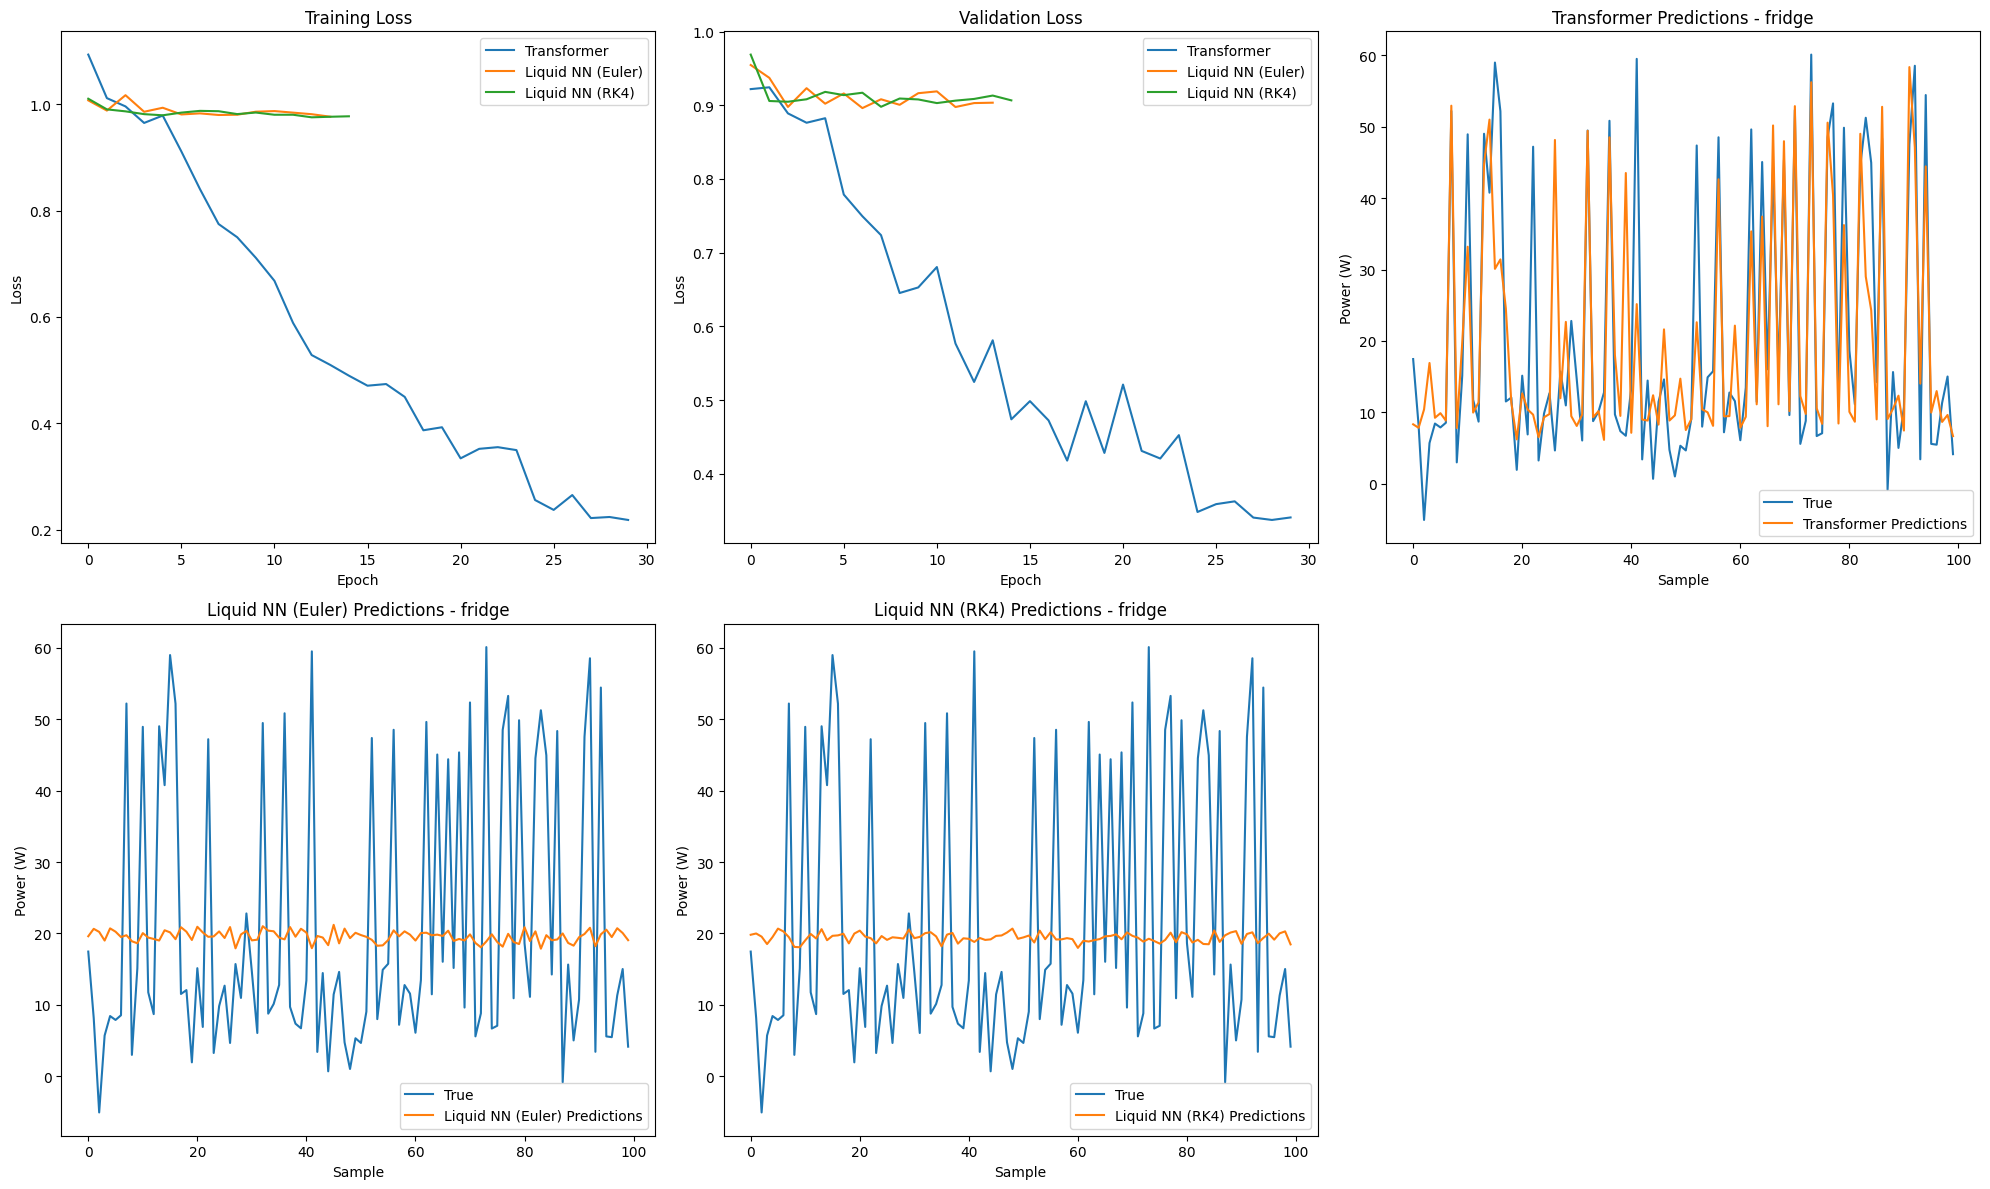


Comparing inference dynamics...
Transformer inference time: 0.011891 seconds
Liquid NN (Euler) inference time: 0.034763 seconds
Liquid NN (RK4) inference time: 0.127192 seconds


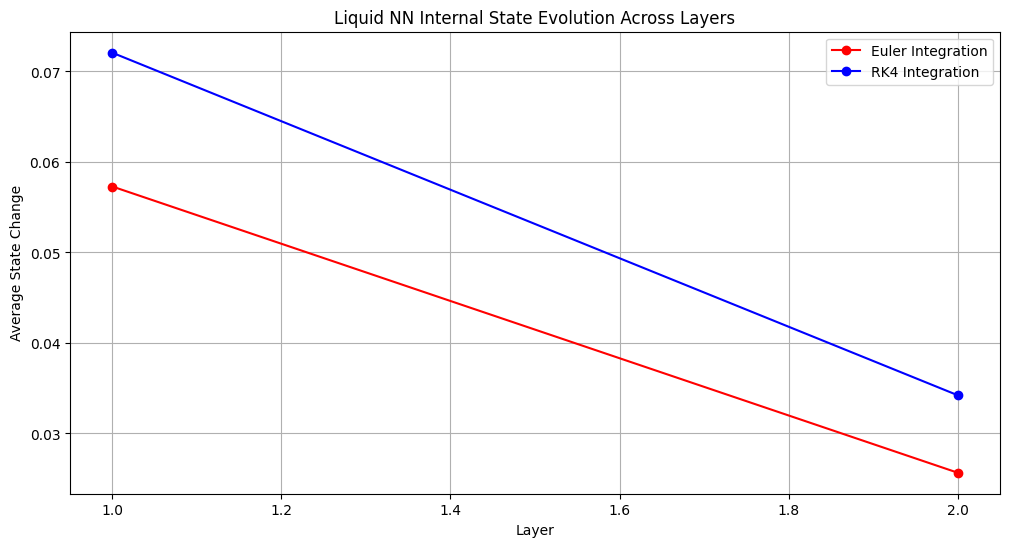


Comparing weight distributions...


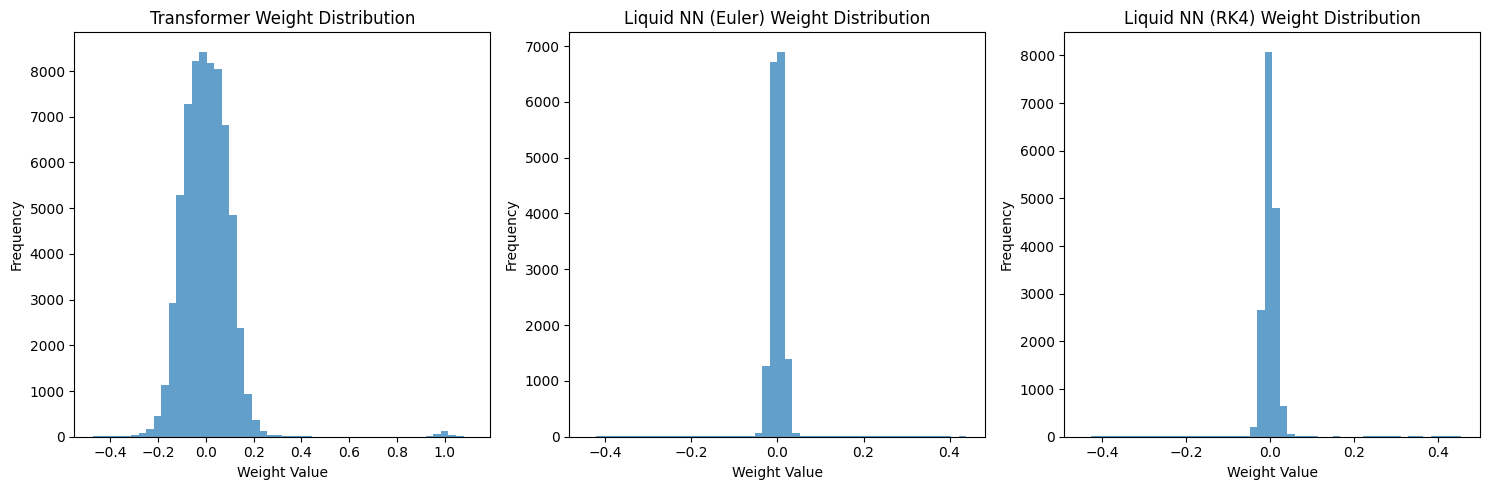

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import os
import requests
from zipfile import ZipFile
from io import BytesIO
import time

# Define the Transformer model for time series forecasting
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=8,
                 num_encoder_layers=3, dim_feedforward=512, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=num_encoder_layers
        )
        # Output projection
        self.output_projection = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x shape: [batch, seq_len, input_dim]
        x = self.input_projection(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        return self.output_projection(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [batch, seq_len, d_model]
        return x + self.pe[:, :x.size(1), :]

# Define the Liquid Neural Network model for time series forecasting
class LiquidBlock(nn.Module):
    def __init__(self, hidden_dim, time_steps=10, dt=0.1):
        super(LiquidBlock, self).__init__()
        self.hidden_dim = hidden_dim
        self.time_steps = time_steps
        self.dt = dt  # Time step size for numerical integration

        # Learnable parameters for the ODE: dh/dt = f(h, t)
        self.W = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.U = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.bias = nn.Parameter(torch.zeros(hidden_dim))

        # Nonlinearity for the vector field
        self.act = nn.Tanh()

    def vector_field(self, h):
        """Compute the vector field for the ODE: dh/dt = f(h, t)"""
        f_h = self.act(torch.matmul(h, self.W))
        stability_term = torch.matmul(h, self.U) + self.bias
        return f_h + stability_term

    def forward(self, h):
        # h shape: [batch, seq_len, hidden_dim]
        batch_size, seq_len, _ = h.shape

        outputs = []

        for t in range(seq_len):
            h_t = h[:, t, :]  # [batch, hidden_dim]

            # Solve the ODE: dh/dt = f(h, t) using Euler integration
            for _ in range(self.time_steps):
                # Compute the derivative
                dh_dt = self.vector_field(h_t)

                # Euler integration: h(t+dt) = h(t) + dt * dh/dt
                h_t = h_t + self.dt * dh_dt

            outputs.append(h_t.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # [batch, seq_len, hidden_dim]

class LiquidBlockRK4(nn.Module):
    def __init__(self, hidden_dim, time_steps=10, dt=0.1):
        super(LiquidBlockRK4, self).__init__()
        self.hidden_dim = hidden_dim
        self.time_steps = time_steps
        self.dt = dt  # Time step size for numerical integration

        # Learnable parameters
        self.W = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.U = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.01)
        self.bias = nn.Parameter(torch.zeros(hidden_dim))

        # Nonlinearity
        self.act = nn.Tanh()

    def vector_field(self, h):
        """Compute the vector field for the ODE: dh/dt = f(h, t)"""
        f_h = self.act(torch.matmul(h, self.W))
        stability_term = torch.matmul(h, self.U) + self.bias
        return f_h + stability_term

    def rk4_step(self, h):
        """Perform one RK4 integration step"""
        k1 = self.vector_field(h)
        k2 = self.vector_field(h + self.dt * k1 / 2)
        k3 = self.vector_field(h + self.dt * k2 / 2)
        k4 = self.vector_field(h + self.dt * k3)

        return h + (self.dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    def forward(self, h):
        # h shape: [batch, seq_len, hidden_dim]
        batch_size, seq_len, _ = h.shape

        outputs = []

        for t in range(seq_len):
            h_t = h[:, t, :]  # [batch, hidden_dim]

            # Solve the ODE using RK4 integration
            for _ in range(self.time_steps):
                h_t = self.rk4_step(h_t)

            outputs.append(h_t.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # [batch, seq_len, hidden_dim]

class LiquidNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, time_steps=10, dt=0.1, use_rk4=False):
        super(LiquidNeuralNetwork, self).__init__()

        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Liquid layers with either Euler or RK4 integration
        self.liquid_layers = nn.ModuleList()
        for _ in range(num_layers):
            if use_rk4:
                self.liquid_layers.append(LiquidBlockRK4(hidden_dim, time_steps=time_steps, dt=dt))
            else:
                self.liquid_layers.append(LiquidBlock(hidden_dim, time_steps=time_steps, dt=dt))

        # Output projection
        self.output_projection = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: [batch, seq_len, input_dim]
        h = self.input_projection(x)

        for layer in self.liquid_layers:
            h = layer(h)

        return self.output_projection(h)

# UK-DALE Dataset processor
class UKDALEDataset(Dataset):
    def __init__(self, data, seq_length, target_appliance, features=None, prediction_horizon=1):
        self.data = data
        self.seq_length = seq_length
        self.target_appliance = target_appliance
        self.prediction_horizon = prediction_horizon
        if features is None:
            # Use all columns except the target as features
            self.features = [col for col in data.columns if col != target_appliance]
        else:
            self.features = features
        # Prepare data
        self.X = self.data[self.features].values
        self.y = self.data[self.target_appliance].values
        # Standardize data
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        self.X = self.X_scaler.fit_transform(self.X)
        self.y = self.y_scaler.fit_transform(self.y.reshape(-1, 1)).flatten()

    def __len__(self):
        # Adjusted length to account for sequence length and prediction horizon
        return len(self.data) - self.seq_length - self.prediction_horizon + 1

    def __getitem__(self, idx):
        # Get sequence and target
        X_seq = self.X[idx:idx+self.seq_length]
        y_seq = self.y[idx:idx+self.seq_length]
        # For forecasting, the target is the next value(s) after the sequence
        y_target = self.y[idx+self.seq_length:idx+self.seq_length+self.prediction_horizon]
        return {
            'X': torch.FloatTensor(X_seq),
            'y_seq': torch.FloatTensor(y_seq),
            'y_target': torch.FloatTensor(y_target)
        }

    def inverse_transform_y(self, y):
        """Transform predictions back to original scale"""
        return self.y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()

# Download and prepare UK-DALE dataset
def prepare_ukdale_data(temp_folder="./data", house_id=1):
    """
    Download and prepare UK-DALE dataset for a specific house
    """
    if not os.path.exists(temp_folder):
        os.makedirs(temp_folder)
    # Download 1-second resolution data for the specified house
    base_url = "https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2017/UK-DALE-disaggregated"
    house_file = f"house_{house_id}.zip"
    print(f"Note: In a real application, you would download the UK-DALE dataset from:")
    print(f"URL: {base_url}/{house_file}")
    print("For this example, we'll simulate the dataset.")
    # Create simulated data for demonstration purposes
    timestamps = pd.date_range('2015-01-01', '2015-01-02', freq='1min')
    num_points = len(timestamps)
    # Create a synthetic dataset
    np.random.seed(42)
    # Simulated aggregate and appliance power
    aggregate = 100 + 50 * np.sin(np.linspace(0, 10*np.pi, num_points)) + 30 * np.random.randn(num_points)
    # Add some appliance patterns
    fridge = 10 + 40 * (np.sin(np.linspace(0, 40*np.pi, num_points)) > 0.7).astype(float) + 5 * np.random.randn(num_points)
    kettle = np.zeros(num_points)
    kettle_times = np.random.choice(range(num_points), 5)
    for t in kettle_times:
        if t + 5 < num_points:
            kettle[t:t+5] = 2000 + 100 * np.random.randn(5)
    microwave = np.zeros(num_points)
    microwave_times = np.random.choice(range(num_points), 3)
    for t in microwave_times:
        if t + 10 < num_points:
            microwave[t:t+10] = 1000 + 50 * np.random.randn(10)
    toaster = np.zeros(num_points)
    toaster_times = np.random.choice(range(num_points), 2)
    for t in toaster_times:
        if t + 3 < num_points:
            toaster[t:t+3] = 1200 + 30 * np.random.randn(3)
    # Create dataframe
    df = pd.DataFrame({
        'aggregate': aggregate,
        'fridge': fridge,
        'kettle': kettle,
        'microwave': microwave,
        'toaster': toaster,
        'timestamp': timestamps
    })
    # Add time features
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['minute'] = df['timestamp'].dt.minute
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df

# Train and evaluate model
def train_model(model, train_loader, val_loader, device, epochs=50, lr=0.001, patience=10):
    """
    Train model with early stopping
    """
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            X = batch['X'].to(device)
            y_target = batch['y_target'].to(device)
            optimizer.zero_grad()
            # Forward pass - predict the target sequence
            output = model(X)
            # Use the last time step prediction for forecasting
            pred = output[:, -1, :]
            loss = criterion(pred, y_target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                X = batch['X'].to(device)
                y_target = batch['y_target'].to(device)
                output = model(X)
                pred = output[:, -1, :]
                loss = criterion(pred, y_target)
                val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_loss:.6f}')
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))
    return model, train_losses, val_losses

# Evaluate model on test set
def evaluate_model(model, test_loader, device, dataset):
    """
    Evaluate model on test set
    """
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            X = batch['X'].to(device)
            y_target = batch['y_target'].cpu().numpy()
            output = model(X)
            pred = output[:, -1, :].cpu().numpy()
            y_true.extend(y_target)
            y_pred.extend(pred)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Transform back to original scale
    y_true_orig = dataset.inverse_transform_y(y_true)
    y_pred_orig = dataset.inverse_transform_y(y_pred)
    # Calculate metrics
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    return {
        'mae': mae,
        'rmse': rmse,
        'y_true': y_true_orig,
        'y_pred': y_pred_orig
    }

# Main function to run the comparison
def compare_models_on_ukdale():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    # Prepare data
    print("Preparing UK-DALE dataset...")
    data = prepare_ukdale_data()
    # Parameters
    seq_length = 30  # 30 minute window
    target_appliance = 'fridge'  # Predicting fridge consumption
    features = ['aggregate', 'hour', 'day', 'minute', 'dayofweek']
    prediction_horizon = 1  # Predict 1 step ahead
    # Create dataset
    dataset = UKDALEDataset(
        data,
        seq_length=seq_length,
        target_appliance=target_appliance,
        features=features,
        prediction_horizon=prediction_horizon
    )
    # Split data
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # Define models
    input_dim = len(features)
    output_dim = prediction_horizon
    # Transformer model
    transformer = TimeSeriesTransformer(
        input_dim=input_dim,
        output_dim=output_dim,
        d_model=64,
        nhead=4,
        num_encoder_layers=2,
        dim_feedforward=128,
        dropout=0.1
    )
    # Liquid Neural Network model with Euler integration
    liquid_nn = LiquidNeuralNetwork(
        input_dim=input_dim,
        hidden_dim=64,
        output_dim=output_dim,
        num_layers=2,
        time_steps=5,
        dt=0.1,
        use_rk4=False
    )
        # Liquid Neural Network model with RK4 integration
    liquid_nn_rk4 = LiquidNeuralNetwork(
        input_dim=input_dim,
        hidden_dim=64,
        output_dim=output_dim,
        num_layers=2,
        time_steps=5,
        dt=0.1,
        use_rk4=True
    )
    # Count parameters
    transformer_params = sum(p.numel() for p in transformer.parameters())
    liquid_nn_params = sum(p.numel() for p in liquid_nn.parameters())
    liquid_nn_rk4_params = sum(p.numel() for p in liquid_nn_rk4.parameters())
    print(f"Transformer parameters: {transformer_params}")
    print(f"Liquid NN (Euler) parameters: {liquid_nn_params}")
    print(f"Liquid NN (RK4) parameters: {liquid_nn_rk4_params}")
    # Train and evaluate Transformer
    print("\nTraining Transformer model...")
    start_time = time.time()
    transformer, transformer_train_losses, transformer_val_losses = train_model(
        transformer, train_loader, val_loader, device, epochs=30, patience=7
    )
    transformer_training_time = time.time() - start_time
    print(f"Transformer training time: {transformer_training_time:.2f} seconds")
    transformer_results = evaluate_model(transformer, test_loader, device, dataset)
    # Train and evaluate Liquid Neural Network (Euler)
    print("\nTraining Liquid Neural Network model with Euler integration...")
    start_time = time.time()
    liquid_nn, liquid_nn_train_losses, liquid_nn_val_losses = train_model(
        liquid_nn, train_loader, val_loader, device, epochs=30, patience=7
    )
    liquid_nn_training_time = time.time() - start_time
    print(f"Liquid NN (Euler) training time: {liquid_nn_training_time:.2f} seconds")
    liquid_nn_results = evaluate_model(liquid_nn, test_loader, device, dataset)
        # Train and evaluate Liquid Neural Network (RK4)
    print("\nTraining Liquid Neural Network model with RK4 integration...")
    start_time = time.time()
    liquid_nn_rk4, liquid_nn_rk4_train_losses, liquid_nn_rk4_val_losses = train_model(
        liquid_nn_rk4, train_loader, val_loader, device, epochs=30, patience=7
    )
    liquid_nn_rk4_training_time = time.time() - start_time
    print(f"Liquid NN (RK4) training time: {liquid_nn_rk4_training_time:.2f} seconds")
    liquid_nn_rk4_results = evaluate_model(liquid_nn_rk4, test_loader, device, dataset)
    # Compare results
    print("\nResults Comparison:")
    print(f"Transformer - MAE: {transformer_results['mae']:.4f}, RMSE: {transformer_results['rmse']:.4f}")
    print(f"Liquid NN (Euler) - MAE: {liquid_nn_results['mae']:.4f}, RMSE: {liquid_nn_results['rmse']:.4f}")
    print(f"Liquid NN (RK4) - MAE: {liquid_nn_rk4_results['mae']:.4f}, RMSE: {liquid_nn_rk4_results['rmse']:.4f}")
    # Plot results
    plt.figure(figsize=(20, 12))
    # Plot training losses
    plt.subplot(2, 3, 1)
    plt.plot(transformer_train_losses, label='Transformer')
    plt.plot(liquid_nn_train_losses, label='Liquid NN (Euler)')
    plt.plot(liquid_nn_rk4_train_losses, label='Liquid NN (RK4)')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plot validation losses
    plt.subplot(2, 3, 2)
    plt.plot(transformer_val_losses, label='Transformer')
    plt.plot(liquid_nn_val_losses, label='Liquid NN (Euler)')
    plt.plot(liquid_nn_rk4_val_losses, label='Liquid NN (RK4)')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plot predictions for a sample of test data
    sample_size = min(100, len(transformer_results['y_true']))
    plt.subplot(2, 3, 3)
    plt.plot(transformer_results['y_true'][:sample_size], label='True')
    plt.plot(transformer_results['y_pred'][:sample_size], label='Transformer Predictions')
    plt.title(f'Transformer Predictions - {target_appliance}')
    plt.xlabel('Sample')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.subplot(2, 3, 4)
    plt.plot(liquid_nn_results['y_true'][:sample_size], label='True')
    plt.plot(liquid_nn_results['y_pred'][:sample_size], label='Liquid NN (Euler) Predictions')
    plt.title(f'Liquid NN (Euler) Predictions - {target_appliance}')
    plt.xlabel('Sample')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.subplot(2, 3, 5)
    plt.plot(liquid_nn_rk4_results['y_true'][:sample_size], label='True')
    plt.plot(liquid_nn_rk4_results['y_pred'][:sample_size], label='Liquid NN (RK4) Predictions')
    plt.title(f'Liquid NN (RK4) Predictions - {target_appliance}')
    plt.xlabel('Sample')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.tight_layout()

    plt.show()
    #plt.savefig('transformer_vs_liquid_nn_ukdale.png')
    #plt.close()
    # Plot inference dynamics
    print("\nComparing inference dynamics...")
    # Use a single batch from test set for inference comparison
    test_batch = next(iter(test_loader))
    X_test = test_batch['X'].to(device)
    # Measure Transformer inference time
    start_time = time.time()
    with torch.no_grad():
        _ = transformer(X_test)
    transformer_inference_time = time.time() - start_time
    # Measure Liquid NN (Euler) inference time
    start_time = time.time()
    with torch.no_grad():
        _ = liquid_nn(X_test)
    liquid_nn_inference_time = time.time() - start_time
        # Measure Liquid NN (RK4) inference time
    start_time = time.time()
    with torch.no_grad():
        _ = liquid_nn_rk4(X_test)
    liquid_nn_rk4_inference_time = time.time() - start_time
    print(f"Transformer inference time: {transformer_inference_time:.6f} seconds")
    print(f"Liquid NN (Euler) inference time: {liquid_nn_inference_time:.6f} seconds")
    print(f"Liquid NN (RK4) inference time: {liquid_nn_rk4_inference_time:.6f} seconds")
    # Plot internal state evolution for Liquid NNs
    # Using first sample from test batch
    x_single = X_test[0:1]  # [1, seq_len, input_dim]
    # For Euler Liquid NN
    with torch.no_grad():
        # Track how internal state evolves through layers of Liquid NN
        h = liquid_nn.input_projection(x_single)
        euler_layer_outputs = [h.clone().cpu().numpy()]
        for layer in liquid_nn.liquid_layers:
            h = layer(h)
            euler_layer_outputs.append(h.clone().cpu().numpy())
                # For RK4 Liquid NN
    with torch.no_grad():
        # Track how internal state evolves through layers of Liquid NN
        h = liquid_nn_rk4.input_projection(x_single)
        rk4_layer_outputs = [h.clone().cpu().numpy()]
        for layer in liquid_nn_rk4.liquid_layers:
            h = layer(h)
            rk4_layer_outputs.append(h.clone().cpu().numpy())
    # Calculate state changes between consecutive layers
    euler_layer_changes = []
    for i in range(1, len(euler_layer_outputs)):
        change = np.mean(np.abs(euler_layer_outputs[i] - euler_layer_outputs[i-1]))
        euler_layer_changes.append(change)
        rk4_layer_changes = []
    for i in range(1, len(rk4_layer_outputs)):
        change = np.mean(np.abs(rk4_layer_outputs[i] - rk4_layer_outputs[i-1]))
        rk4_layer_changes.append(change)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(euler_layer_changes) + 1), euler_layer_changes, 'ro-', label='Euler Integration')
    plt.plot(range(1, len(rk4_layer_changes) + 1), rk4_layer_changes, 'bo-', label='RK4 Integration')
    plt.title('Liquid NN Internal State Evolution Across Layers')
    plt.xlabel('Layer')
    plt.ylabel('Average State Change')
    plt.legend()
    plt.grid(True)

    plt.show()
    #plt.savefig('liquid_nn_state_evolution.png')
    #plt.close()
    # Compare weight distributions
    print("\nComparing weight distributions...")
    # Collect weights from Transformer
    transformer_weights = []
    for name, param in transformer.named_parameters():
        if 'weight' in name and param.requires_grad:
            transformer_weights.append(param.cpu().detach().numpy().flatten())
    transformer_weights = np.concatenate(transformer_weights)
    # Collect weights from Liquid NN (Euler)
    liquid_nn_weights = []
    for name, param in liquid_nn.named_parameters():
        if ('weight' in name or name.endswith('W') or name.endswith('U')) and param.requires_grad:
            liquid_nn_weights.append(param.cpu().detach().numpy().flatten())
    liquid_nn_weights = np.concatenate(liquid_nn_weights)
        # Collect weights from Liquid NN (RK4)
    liquid_nn_rk4_weights = []
    for name, param in liquid_nn_rk4.named_parameters():
        if ('weight' in name or name.endswith('W') or name.endswith('U')) and param.requires_grad:
            liquid_nn_rk4_weights.append(param.cpu().detach().numpy().flatten())
    liquid_nn_rk4_weights = np.concatenate(liquid_nn_rk4_weights)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(transformer_weights, bins=50, alpha=0.7)
    plt.title('Transformer Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.subplot(1, 3, 2)
    plt.hist(liquid_nn_weights, bins=50, alpha=0.7)
    plt.title('Liquid NN (Euler) Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.subplot(1, 3, 3)
    plt.hist(liquid_nn_rk4_weights, bins=50, alpha=0.7)
    plt.title('Liquid NN (RK4) Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.tight_layout()

    plt.show()
    #plt.savefig('weight_distributions.png')
    #plt.close()

if __name__ == '__main__':
    compare_models_on_ukdale()